# Region Searching for KBMOD

The point of this notebook is to do step-by-step exploration of the DEEP dataset that was first run through KBMOD for the first set of papers. That work was led by Hayden Smotherman, hence the reference to that name.

The "Steven" name that appears is Steven Stetzler, who inherited the responsibilities of properly re/processing the entire DEEP dataset through data acquired through 2023.

### Basic Idea
Here we are connecting to an existing Butler/repository with the intent of carrying out queries to find data suitable for KBMOD to use.

#### FAQ

Q: Who wrote this, and when?\
A: Colin Orion Chandler (coc123@uw.edu), late January 2024.

Q: What are the basic requirements to run this?\
A: (a) Epyc access, (b) with the appropriate (LSST w_2022_06) weekly build active, (c) permissions to access the repo_path mentioned below, and (d) an acceptable Kernel in the Jupyter-Hub of Epyc (user or global).

Q: Why don't we just query the DB (e.g., PostGres, SQLite) to get what we need?\
A: Because (a) the underlying schema can (and has/does) change, and (b) the underlying DB does not contain views, meaning that we would have to recreate the very complex relational mapping ourselves. Moreover, aside from (b) being very challenging, the relationship mapping recreation would fail due to the reasons mentioned in (a).

### Initial Setup

In [1]:
# Import packages needed to run the notebook
import lsst
import lsst.daf.butler as dafButler
import lsst.sphgeom as sphgeom

import os
import glob

import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed

import time
from dateutil import parser

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

import progressbar

from astropy.time import Time  # for converting Butler visitInfo.date (TAI) to UTC strings
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.io.fits as fits

import pickle

In [2]:
# We will use some kind of multiprocessing in a few places. Let's see what the sytsem thinks we have available.
# NOTE: we could set limits on executors later using this value, if desired. 2/6/2024 COC

available_cpus = multiprocessing.cpu_count()
print(f"{available_cpus} CPUs were reported as available by the multiprocessing module.")

96 CPUs were reported as available by the multiprocessing module.


In [3]:
# this code will run in different environments, so we need somewhere (not the working directory) to save output
basedir = f'{os.environ["HOME"]}/kbmod_tmp'
os.makedirs(basedir, exist_ok=True)

In [4]:
# set up the Butler
# NOTE: the repo path contains configs that point us to the underlying registry (DB)
# NOTE: do NOT assume there is write protection! (i.e., don't make changes)
repo_path = f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
butler = dafButler.Butler(repo_path)

#### Collections
1. Explore the available collections
2. Construct a list of the collections containing the data we care about.

Different collections hold different datasets.

For the Hayden DEEP repo, the collections we are concerned with are organized by pointing groups (discrete regions on the sky).

We want to figure out what those are, how they are named, and what else is available.

We will also dump a full list of collection names to disk. \
NOTE: as of 2/1/2024, there are 1,292 named collections in the repo.


In [5]:
def get_collection_names(butler, basedir, verbose=False, export=True):
    """
    Making this a function 2/6/2024 COC.
    """
    all_collection_names = []

    for c in sorted(butler.registry.queryCollections("*")):
        all_collection_names.append(c)

    if export == True:
        outfile = f"{basedir}/all_collection_names.lst"
        with open(outfile, "w") as f:
            for c in all_collection_names:
                print(c, file=f)

    if verbose:
        message = f"Found {len(all_collection_names)} collections in the Butler."
        if export == True:
            message += f' Wrote to "{outfile}".'
        print(message)
    return all_collection_names

In [6]:
all_collection_names = get_collection_names(butler=butler, basedir=basedir, verbose=True, export=True)

Found 1292 collections in the Butler. Wrote to "/astro/users/coc123/kbmod_tmp/all_collection_names.lst".


In [7]:
# We looked through the collections already.
# We will string manipulate to get to what we need.
# Previously, we used a list file on disk. (This could be a better option for some users.)


def get_desired_collections(all_collections_list, desired_collection_list=None):
    """
    Produce a list of collections that will be used for querying the Butler.

    If desired_collection_list is None, then a hard-wired "default" approach
    (for Haden/DEEP) is carried out, requiring:
        1. "Pointing" must be in the collection name.
        2. "/imdiff_r/" must be in the collection name.
        3. "/2021" may not be in the collection name.

    Otherwise, desired_collection_list can be either
        1. a Python list of desired collection names, or
        2. a filename (ending in .lst) that specifies the desired collections.
    Either way, the collection names are verified against the (required) collections_list.

    Made this into a function 2/6/2024 COC.

    NOTE/TODO: untested are the supplied list and list file approaches.
    """

    desired_collections = []

    if desired_collection_list == None:
        for collection_name in all_collection_names:
            if (
                "Pointing" in collection_name
                and "/imdiff_r" in collection_name
                and "/2021" not in collection_name
            ):
                desired_collections.append(collection_name)
    else:
        if type(desired_collection_list) == type(""):
            with open(desired_collection_list, "r") as f:
                for line in f:
                    desired_collections.append(line.strip())
        else:
            for entry in desired_collection_list:
                desired_collections.append(entry)
    #
    # Validate entries
    for entry in desired_collections:
        if entry not in all_collections_list:
            raise KeyError(f'"{entry}" is not in the master list of collections supplied.')
    #
    return desired_collections

In [8]:
desired_collections = get_desired_collections(all_collections_list=all_collection_names)
desired_collections

['PointingGroup006/imdiff_r',
 'PointingGroup008/imdiff_r',
 'PointingGroup009/imdiff_r',
 'PointingGroup016/imdiff_r',
 'PointingGroup018/imdiff_r',
 'PointingGroup019/imdiff_r',
 'PointingGroup021/imdiff_r',
 'PointingGroup023/imdiff_r']

In [9]:
# ASIDE: there is a set of collections with dates in their names
#   (e.g., PointingGroup006/imdiff_r/20211110T184421Z).
# Those (only?) have the following datasetTypes, (so we use the name without the date for all the datasetTypes):
# Across all collections, we see the following numbers by datasetType:
# 47383      deepDiff_diaSrc
# 8          deepDiff_diaSrc_schema
# 47383      deepDiff_differenceExp
# 29445      deepDiff_warpedExp
# 8          imageDifference_config
# 17942      imageDifference_log
# 47383      imageDifference_metadata
# 8          packages

# which is too little? we we will snag the parent Collections (stripping dates)

#### datasetTypes

Here we explore another dimension of the Butler: datasetType.

tldr; we just care about one currently: deepDiff_differenceExp

In [10]:
# TIMING NOTE: about 2 minutes here
#
# Maybe a KBMOD user must know which datasetType(s) they need?
# Here we show how to explore them to figure that out.
#
# NOTE: we tested two approaches,
#   (a) iterating over desired_collections, and
#   (b) supply desired_collections.
# The output was the same, but the iterating method took 268s, and the supplied method took 97s.
# There *was* a point where we thought we were seeing different results depending on the approach,
# but this has been sorted out. (COC suspects a testing break in a loop somwhere.)
# COC NTS: [TODO] function, [TODO] caching


def getDatasetTypeStats(butler, overwrite=False):
    """
    Get information on all datasetTypes found in a Butler.
    TODO implement caching if desired. If not, get rid of overwrite option.
    2/1/2024 COC
    """
    datasetTypes = {}

    cache_file = f"{basedir}/dataset_types.csv"
    cache_exists = False
    if len(glob.glob(cache_file)) > 0:
        cache_exists = True

    if overwrite == False and cache_exists == True:
        print(f"Recycling {cache_file} as overwrite was False...")
        with open(cache_file, "r") as f:
            for line in f:
                print(line)
                line = line.strip().split(",")
                datasetTypes[line[0]] = int(line[1])
        print(f"Read {len(datasetTypes)} datasetTypes from disk.")
        return datasetTypes

    q = sorted(butler.registry.queryDatasetTypes())

    with progressbar.ProgressBar(max_value=len(q)) as bar:
        for j, dt in enumerate(q):
            n = 0
            for i, ref in enumerate(
                butler.registry.queryDatasets(datasetType=dt, collections=desired_collections)
            ):
                n += 1
            if n > 0:
                if dt.name not in datasetTypes:
                    datasetTypes[dt.name] = 0
                datasetTypes[dt.name] += n
            bar.update(j)

    if cache_exists == False or overwrite == True:
        print(f"Saving {len(datasetTypes)} datasetTypes to {cache_file} now...")
        with open(cache_file, "w") as f:
            for key in datasetTypes:
                print(f"{key},{datasetTypes[key]}", file=f)
    else:
        print(f"Saw {len(datasetTypes)} datasetTypes.")
    return datasetTypes

In [11]:
%%time
# TIMING NOTE: this takes roughly 2.5 minutes without cache (2/6/2024 COC)
datasetTypes = getDatasetTypeStats(butler=butler, overwrite=False)

Recycling /astro/users/coc123/kbmod_tmp/dataset_types.csv as overwrite was False...
assembleCoadd_config,8

assembleCoadd_log,268

assembleCoadd_metadata,700

cal_ref_cat,122856

calexp,47403

calexpBackground,47403

calibrate_config,8

calibrate_log,17961

calibrate_metadata,47403

characterizeImage_config,8

characterizeImage_log,18290

characterizeImage_metadata,47423

deepCoadd,693

deepCoadd_directWarp,167085

deepCoadd_inputMap,693

deepCoadd_psfMatchedWarp,167085

deepDiff_diaSrc,47383

deepDiff_diaSrc_schema,8

deepDiff_differenceExp,47383

deepDiff_warpedExp,29445

gaia_DR1_v1,524283

icExp,47423

icExpBackground,47423

icSrc,47423

icSrc_schema,8

imageDifference_config,8

imageDifference_log,17942

imageDifference_metadata,47383

isr_config,8

isr_log,18290

isr_metadata,48422

makeWarp_config,8

makeWarp_log,64924

makeWarp_metadata,167085

overscanRaw,48422

overscan_config,8

overscan_log,18290

overscan_metadata,48422

packages,32

postISRCCD,48422

ps1_pv3_3pi_20170110,

In [12]:
# The number of records for each datasetType.
# This may be especially useful for users who do not yet know which datasetType(s) they need.

print(f"Across all collections, we see the following numbers by datasetType: ")
for dt in datasetTypes:
    print(f"{datasetTypes[dt]!s:10} {dt}")

Across all collections, we see the following numbers by datasetType: 
8          assembleCoadd_config
268        assembleCoadd_log
700        assembleCoadd_metadata
122856     cal_ref_cat
47403      calexp
47403      calexpBackground
8          calibrate_config
17961      calibrate_log
47403      calibrate_metadata
8          characterizeImage_config
18290      characterizeImage_log
47423      characterizeImage_metadata
693        deepCoadd
167085     deepCoadd_directWarp
693        deepCoadd_inputMap
167085     deepCoadd_psfMatchedWarp
47383      deepDiff_diaSrc
8          deepDiff_diaSrc_schema
47383      deepDiff_differenceExp
29445      deepDiff_warpedExp
524283     gaia_DR1_v1
47423      icExp
47423      icExpBackground
47423      icSrc
8          icSrc_schema
8          imageDifference_config
17942      imageDifference_log
47383      imageDifference_metadata
8          isr_config
18290      isr_log
48422      isr_metadata
8          makeWarp_config
64924      makeWarp_log
167085 

In [13]:
# This is the datasetType that we care about.
# NOTE: we should allow this to be a list in case a user needs multiple.
desired_datasetTypes = ["deepDiff_differenceExp"]

### Visit Detector Region (VDR) Querying

Here we will query the Butler and extract all of the "visit_detector_region" information.\
At this stage we are gathering:
1. dataIds for all future queries
2. lsst.sphgeom.region objects

In [14]:
def clean_dataId(dataId, verbose=True):
    """
    We need a way to extract a portable (non-LSST object) version of the DataId.
    A dataId normally looks like a dictionary with keys of instrument, detector, visit.
    4/22/2024 COC
    """
    fields = ["instrument", "detector", "visit"]
    clean_id = {}
    #
    if type(dataId) == type({}) and list(dataId.keys()) == fields:
        if verbose:
            print(f"dataId was already a properly formatted dict: {dataId}.")
        return dataId
    #
    try:
        dataId = dataId.values_tuple()
    except AttributeError as msg:
        if verbose:
            print(f"dataId did not have a values_tuple() attribute. Message was {msg}.")
        pass
    #
    if type(dataId) == type((1, 1, 1)):
        for i, label in enumerate(fields):
            clean_id[label] = dataId[i]
        if verbose:
            print(f"Derived {clean_id} from tuple {dataId}.")
        return clean_id
    #
    for i, label in enumerate(fields):
        try:
            clean_id[label] = dataId[label]
        except KeyError as msg:
            print(f"KeyError for {label} with dataId= {dataId}. Message was: {msg}.")
            break
    #
    if clean_id == {}:
        raise ValueError(f"Failed to create clean_id for dataId={dataId}.")
    #
    return clean_id

In [15]:
def dataId_to_dataIdStr(dataId, force_clean=False, verbose=False):
    """
    We will store a shortened, concatenated version of this unique triple.
    This is needed because dict values in a column are not hashable.
    Example: "{instrument: 'DECam', detector: 1, visit: 898287}" becomes "DECam_1_898287"
    4/23/2024 COC
    """
    if force_clean:
        dataId = clean_dataId(dataId=dataId, verbose=verbose)
    #
    dataId_str = f"{dataId['instrument']}_{dataId['detector']}_{dataId['visit']}"
    #
    if verbose:
        print(f"dataId {dataId} became: {dataId_str}")
    #
    return dataId_str

In [16]:
# test with the case of a dataId that is already a valid dict
dataId_to_dataIdStr(
    dataId={"instrument": "DECam", "detector": 1, "visit": 898287}, force_clean=True, verbose=True
)

dataId was already a properly formatted dict: {'instrument': 'DECam', 'detector': 1, 'visit': 898287}.
dataId {'instrument': 'DECam', 'detector': 1, 'visit': 898287} became: DECam_1_898287


'DECam_1_898287'

In [17]:
def get_vdr_data(butler, desired_collections, desired_datasetTypes, verbose=False):
    """
    Made as function 2/6/2024 COC.
    """
    # VDR === Visit Detector Region
    # VDRs hold what we need in terms of region hashes and unique dataIds.
    # NOTE: this typically takes < 5s to run 2/1/2024 COC
    # NOTE: tried iterating over desired_collections vs supplying desired_collections; same output 2/1/2024 COC

    vdr_dict = {"data_id": [], "region": [], "detector": []}
    #     vdr_ids = []
    #     vdr_regions = []
    #     vdr_detectors = []

    for dt in desired_datasetTypes:
        datasetRefs = butler.registry.queryDimensionRecords(
            "visit_detector_region", datasets=dt, collections=desired_collections
        )
        for ref in datasetRefs:
            vdr_dict["data_id"].append(clean_dataId(ref.dataId, verbose=verbose))
            vdr_dict["region"].append(
                ref.region
            )  # keeping as objects for now; should .encode() for caching/export
            vdr_dict["detector"].append(ref.detector)  # 2/2/2024 COC
            # BUT if we decided to export this or cache this, we should write the encode() version to disk
            #
            example_vdr_ref = ref  # this leaves a VDR Python object we can play with
            # other data available:
            #    id = ref.id# id -- e.g., 1592350 (for DEEP dataset, I think UUIDs for newer Butlers)
            #    visit = ref.dataId.full['visit'] # e.g., 946725
            # vdr_filters.append(ref.dataId.full['band']) # e.g., VR
            # vdr_detectors.append(ref.dataId.full['detector']) # e.g., 1
    df = pd.DataFrame.from_dict(vdr_dict)
    return df, example_vdr_ref

In [18]:
%%time
# TIMING NOTE: requires about 2 seconds 2/6/2024 COC
df, example_vdr_ref = get_vdr_data(
    butler=butler, desired_collections=desired_collections, desired_datasetTypes=desired_datasetTypes
)

CPU times: user 2.05 s, sys: 79.6 ms, total: 2.13 s
Wall time: 2.64 s


In [19]:
# notice the dataId type is not a plain tuple; so we created a function clean_dataId() to handle this.
type(example_vdr_ref.dataId)

lsst.daf.butler.core.dimensions._coordinate._BasicTupleDataCoordinate

In [20]:
# We also need a string version of the dataId that is hashable. 4/23/2024 COC
df["data_id_str"] = [dataId_to_dataIdStr(dataId=dataId) for dataId in df["data_id"]]

In [21]:
df

,data_id,region,detector,data_id_str
0,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847372525065534...,1,DECam_1_898286
1,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847381014554984...,1,DECam_1_898287
2,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847383417970056...,1,DECam_1_898288
3,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847382159041213...,1,DECam_1_898289
4,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847381374341414...,1,DECam_1_898290
...,...,...,...,...
47378,"{'instrument': 'DECam', 'detector': 62, 'visit...","ConvexPolygon([UnitVector3d(0.987608537646486,...",62,DECam_62_946172
47379,"{'instrument': 'DECam', 'detector': 62, 'visit...",ConvexPolygon([UnitVector3d(0.9876085083003562...,62,DECam_62_946173
47380,"{'instrument': 'DECam', 'detector': 62, 'visit...",ConvexPolygon([UnitVector3d(0.9876085761885252...,62,DECam_62_946174
47381,"{'instrument': 'DECam', 'detector': 62, 'visit...",ConvexPolygon([UnitVector3d(0.9876085761885252...,62,DECam_62_946175


In [22]:
print(f"We found {len(df['data_id'])} regions spanning the {len(desired_collections)} desired collections.")

We found 47383 regions spanning the 8 desired collections.


In [23]:
# For demonstration purposes we still have the last "ref" from the last cell's iteration
example_vdr_ref

visit_detector_region.RecordClass(instrument='DECam', detector=62, visit=946176, region=ConvexPolygon([UnitVector3d(0.9876086828694174, -0.13336028508776862, -0.08272922024438323), UnitVector3d(0.9873378171284917, -0.13332652431396907, -0.08595389916869185), UnitVector3d(0.9881047366097594, -0.12752395595185462, -0.08594573955553172), UnitVector3d(0.9883760335240734, -0.12755303452468866, -0.0827226676235914)]))

In [24]:
# This is the unique dataId we would need to retrieve this specific image later
example_vdr_ref.dataId

{instrument: 'DECam', detector: 62, visit: 946176}

In [25]:
# The unique dataId is made up of the following attributes:
print(
    f"example_vdr_ref.instrument = {example_vdr_ref.instrument}, \
    example_vdr_ref.detector = {example_vdr_ref.detector}, \
    example_vdr_ref.visit = {example_vdr_ref.visit}"
)

example_vdr_ref.instrument = DECam,     example_vdr_ref.detector = 62,     example_vdr_ref.visit = 946176


In [26]:
# This is the region hash we would use for "region matching" later
example_vdr_ref.region.encode()

b'p\xddnE\x86}\x9a\xef?\x0f\xc3\x84\'\xf3\x11\xc1\xbf\x80\x8a_\xff\xbd-\xb5\xbf\x04xUzE\x98\xef?\x94\x15\xcf\xf2\xd7\x10\xc1\xbf\x9d\xa9\xe4!\x13\x01\xb6\xbf\x1d_\x18\xd3\x8d\x9e\xef?\x80\x87"z\xb4R\xc0\xbff\x1d\x9f<\x8a\x00\xb6\xbf\xe4Z\x84\xc6\xc6\xa0\xef?\x1f\x01\xe5g\xa8S\xc0\xbf\xba\xc9\x14\x10P-\xb5\xbf'

In [27]:
# We check to see if we can crawl to other data from the dataId (False means no).
example_vdr_ref.dataId.hasRecords()

False

# Dataframe Assembly

This used to contain more, but after I moved everything to a dictionary, then a DF, this became less important.
TODO determine where this should go. Or remove.

In [28]:
%%time

# Save the dataframe to a pickle file for easier resuming of the notebook
# Size was < 20 Mb 2/5/2024 COC
# COC Note: this was not that useful, maybe TODO remove
df_filename = f"{basedir}/region_search_df.pickle"
df.to_pickle(df_filename)

CPU times: user 112 ms, sys: 20.9 ms, total: 133 ms
Wall time: 196 ms


In [29]:
# load the pickle
# df = pd.read_pickle(file_name)

### Instrument handling
Some Butler queries require the instrument to be specified.\
For now, we are just supplying the one we care about (KLUDGE).\
It's a list so we can mix-and-match shift-and-stack across instruments(!).\
NOTE: will leave this as a list for future-proofing purpose

In [30]:
def getInstruments(butler, vdr_ids, first_instrument_only=True, datasetType=desired_datasetTypes[0]):
    """Iterate through our records to determine which instrument(s) are involved.
    Return a list of the identified instruments.
    If first_instrument_only is True, stop as soon as we found an instrument.
    """
    # KLUDGE: snag the instrument name of the first record we find in a visitInfo query.
    instrument_names = []
    for i, dataId in enumerate(vdr_ids):
        visitInfo = butler.get(f"{datasetType}.visitInfo", dataId=dataId, collections=desired_collections)
        instrument_name = visitInfo.instrumentLabel
        if instrument_name not in instrument_names:
            print(f'Found {instrument_name}. Adding to "desired_instruments" now.')
            instrument_names.append(instrument_name)
        if first_instrument_only == True and len(instrument_names) > 0:
            print(
                f"WARNING: we are not iterating over all rows to find instruments, just taking the first one."
            )
            break
    return instrument_names

In [31]:
%%time
desired_instruments = getInstruments(butler=butler, vdr_ids=df["data_id"])

Found DECam. Adding to "desired_instruments" now.
CPU times: user 1.07 s, sys: 99 ms, total: 1.17 s
Wall time: 1.19 s


### Butler Retrieval Example

A quick stop to see how we can grab the full Butler record via a dataId.

In [32]:
%%time
# Back to the dataId, we can actually fetch the image from the Butler
# TIMING NOTE: it takes 1 to 2 seconds to do this, so we won't be able to do this at scale

example_butler_get = butler.get(
    desired_datasetTypes[0], collections=desired_collections, dataId=example_vdr_ref.dataId
)

CPU times: user 947 ms, sys: 96.7 ms, total: 1.04 s
Wall time: 1.06 s


In [33]:
# let us try this without the special DataID Butler object 4/22/2024 COC
print(f"The example_vdr_ref has a .dataId of type {type(example_vdr_ref.dataId)}.")  # .values_tuple()
print(example_vdr_ref.dataId.values())
example_vdr_ref_dataId_manual = clean_dataId(dataId=example_vdr_ref.dataId, verbose=True)
# example_vdr_ref_dataId_manual = {}
# for i in ['instrument', 'detector', 'visit']:
#     example_vdr_ref_dataId_manual[i] = example_vdr_ref.dataId[i]
print(f"Our manual vdr ref: {example_vdr_ref_dataId_manual}.")

The example_vdr_ref has a .dataId of type <class 'lsst.daf.butler.core.dimensions._coordinate._BasicTupleDataCoordinate'>.
ValuesView({instrument: 'DECam', detector: 62, visit: 946176})
dataId did not have a values_tuple() attribute. Message was '_BasicTupleDataCoordinate' object has no attribute 'values_tuple'.
Our manual vdr ref: {'instrument': 'DECam', 'detector': 62, 'visit': 946176}.


In [34]:
example_butler_get_manual_dataId = butler.get(
    desired_datasetTypes[0], collections=desired_collections, dataId=example_vdr_ref_dataId_manual
)

In [35]:
# with our alternate (manual) approach:
example_butler_get_manual_dataId.detector.getId()

62

In [36]:
# which matches the same attribute via our original query:
example_butler_get.detector.getId()

62

In [37]:
example_butler_get.filterLabel.bandLabel

'VR'

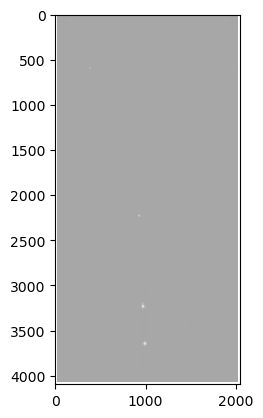

In [38]:
# we can even view the image right here
plt.imshow(example_butler_get.image.array, cmap="gray")

In [39]:
# There IS a WCS here, which we did not see in the earlier VDR
example_butler_get.wcs

FITS standard SkyWcs:
Sky Origin: (352.4630539808, -4.8516830845)
Pixel Origin: (1126.14, 1991.36)
Pixel Scale: 0.262593 arcsec/pixel

In [40]:
# We can access all kinds of metadata this way.
# NOTE: keywords are source data-dependent.
# NOTE: this linkage works with butler.get() but not necessarily elsewhere.
meta = example_butler_get.getInfo().getMetadata()

print(f"Here are all the keywords available from this image:")
for k in meta.keys():
    print(k)

Here are all the keywords available from this image:
NEXTEND
PROCTYPE
PRODTYPE
PIXSCAL1
PIXSCAL2
FILENAME
TELESCOP
OBSERVAT
INSTRUME
EXPREQ
OBSID
TIME-OBS
OPENSHUT
EXPNUM
OBJECT
OBSTYPE
CAMSHUT
PROGRAM
OBSERVER
PROPOSER
DTPI
PROPID
EXCLUDED
SEQID
SEQNUM
SEQTOT
AOS
BCAM
GUIDER
SKYSTAT
FILTER
INSTANCE
ERRORS
TELEQUIN
TELSTAT
RA
DEC
TELRA
TELDEC
HA
ZD
AZ
DOMEAZ
ZPDELRA
ZPDELDEC
TELFOCUS
VSUB
GSKYPHOT
LSKYPHOT
WINDSPD
WINDDIR
PRESSURE
DIMMSEE
DIMM2SEE
MASS2
ASTIG1
ASTIG2
OUTTEMP
AIRMASS
GSKYVAR
GSKYHOT
LSKYVAR
LSKYHOT
LSKYPOW
MSURTEMP
MAIRTEMP
UPTRTEMP
LWTRTEMP
PMOSTEMP
UTN-TEMP
UTS-TEMP
UTW-TEMP
UTE-TEMP
PMN-TEMP
PMS-TEMP
PMW-TEMP
PME-TEMP
DOMELOW
DOMEHIGH
DOMEFLOR
G-MEANX
G-MEANY
DONUTFS4
DONUTFS3
DONUTFS2
DONUTFS1
G-FLXVAR
G-MEANXY
DONUTFN1
DONUTFN2
DONUTFN3
DONUTFN4
TIME_RECORDED
G-FEEDBK
G-CCDNUM
DOXT
G-MAXX
FADZ
FADY
FADX
G-MODE
FAYT
DODZ
DODY
DODX
MULTIEXP
SKYUPDAT
G-SEEING
G-TRANSP
G-MEANY2
DOYT
G-LATENC
LUTVER
FAXT
G-MAXY
G-MEANX2
SISPIVER
CONSTVER
HDRVER
DTPROPID
DTCALDAT
DTSITE


### URI / URL / Path Handling
Here we grab URIs for the dataIds we need.

In [41]:
# NOTE: getURIs() does not work as you'd think (i.e., it only handles a single dataId)
# butler.getURIs(desired_datasetTypes[0], vdr_ids, collections=desired_collections)

In [42]:
# The single-thead approach (below) requires some 2 hours to execute. So instead we will multiprocess.
# paths = [butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections) for dataId in vdr_ids]


def chunked_dataIds(dataIds, chunk_size=200):
    """Yield successive chunk_size chunks from dataIds."""
    for i in range(0, len(dataIds), chunk_size):
        yield dataIds[i : i + chunk_size]


def get_uris(dataIds_chunk, repo_path, desired_datasetTypes, desired_collections):
    """Fetch URIs for a list of dataIds."""
    chunk_uris = []
    butler = dafButler.Butler(repo_path)
    for dataId in dataIds_chunk:
        try:
            uri = butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections)
            uri = uri.geturl()  # Convert to URL string
            chunk_uris.append(uri)
        except Exception as e:
            print(f"Failed to retrieve path for dataId {dataId}: {e}")
    return chunk_uris


def getURIs(butler, dataIds, repo_path, desired_datasetTypes, desired_collections, overwrite=False):
    """
    Get URIs from a Butler for a set of dataIDs.
    Cache results to disk for future runs.
    TODO: consider exporting as CSV so we can validate URIs against dataIds. 2/6/2024 COC
    Updated 2/5/2024 COC
    """
    paths = []

    cache_file = f"{basedir}/uri_cache.lst"
    cached_exists = False
    if len(glob.glob(cache_file)) > 0:
        cached_exists = True

    if cached_exists == True and overwrite == False:
        with open(cache_file, "r") as f:
            for line in f:
                paths.append(line.strip())
        print(f"Recycled {len(paths)} paths from {cache_file} as overwrite was {overwrite}.")
        return paths

    # Prepare dataId chunks
    dataId_chunks = list(chunked_dataIds(dataIds))

    # Execute get_uris in parallel and preserve order
    with ProcessPoolExecutor() as executor:
        # Initialize progress bar
        with progressbar.ProgressBar(max_value=len(dataId_chunks)) as bar:
            # Use map to execute get_uris on each chunk and maintain order
            result_chunks = list(
                executor.map(
                    get_uris,
                    dataId_chunks,
                    [repo_path] * len(dataId_chunks),
                    [desired_datasetTypes] * len(dataId_chunks),
                    [desired_collections] * len(dataId_chunks),
                )
            )

            for i, chunk_uris in enumerate(result_chunks):
                paths.extend(chunk_uris)  # Add the retrieved URIs to the main list
                bar.update(i)

    with open(cache_file, "w") as f:
        for path in paths:
            print(path, file=f)
        print(f"Wrote {len(paths)} paths to disk for caching purposes.")

    return paths

In [43]:
%%time

# TIMING NOTE: This required 90s uncached 2/5/2024 COC

df["uri"] = getURIs(
    butler=butler,
    dataIds=df["data_id"],
    repo_path=repo_path,
    desired_datasetTypes=desired_datasetTypes,
    desired_collections=desired_collections,
    overwrite=False,
)

Recycled 47383 paths from /astro/users/coc123/kbmod_tmp/uri_cache.lst as overwrite was False.
CPU times: user 16.6 ms, sys: 18.7 ms, total: 35.3 ms
Wall time: 34.4 ms


In [44]:
# example URI
df["uri"].iloc()[0]

'file:///epyc/users/smotherh/DEEP/PointingGroups/butler-repo/PointingGroup021/imdiff_r/20210723T174135Z/deepDiff_differenceExp/20190927/VR/VR_DECam_c0007_6300.0_2600.0/898286/deepDiff_differenceExp_DECam_VR_VR_DECam_c0007_6300_0_2600_0_898286_S29_PointingGroup021_imdiff_r_20210723T174135Z.fits'

### Timestamp Handling
Here we will access the timestamp (datetime) information from the Butler for our records.

In [45]:
%%time
# Now we want to get metadata like datetime, exposure time, etc.
for i, dataId in enumerate(df["data_id"]):
    visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
    print(i, visitInfo.date, visitInfo.exposureTime, visitInfo.boresightRaDec)
    break
# We have the visitInfo object for the exploration below.

0 DateTime("2019-09-27T00:20:59.932016000", TAI) 120.0 (351.3806941054, -5.2403083277)
CPU times: user 92.1 ms, sys: 8.71 ms, total: 101 ms
Wall time: 125 ms


In [46]:
# That visitInfo.date format may not look familiar. Let's find out why:
type(visitInfo.date)

lsst.daf.base.dateTime.dateTime.DateTime

In [47]:
# Let's convert to a plain string, UTC (handles 37 s offset).
t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
str(t.utc)

'2019-09-27T00:20:22.932'

In [48]:
# New parallel version with order-preservation redone 2/7/2024 COC


# Define get_timestamps at the top level of your module
def get_timestamps(dataIds_chunk, repo_path, desired_collections, datasetType=desired_datasetTypes[0]):
    """
    Adding datasetType 4/22/2024 COC
    """
    chunked_data = []
    butler = dafButler.Butler(repo_path)
    for dataId in dataIds_chunk:
        try:
            visitInfo = butler.get(f"{datasetType}.visitInfo", dataId=dataId, collections=desired_collections)
            t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
            tutc = str(t.utc)
            chunked_data.append(tutc)
        except Exception as e:
            print(f"Failed to retrieve timestamp for dataId {dataId}: {e}")
    return chunked_data


def getTimestamps(dataIds, overwrite=False):
    timestamps = []
    cache_file = f"{basedir}/vdr_timestamps.lst"

    if not overwrite and glob.glob(cache_file):
        print("Overwrite is False, so we will read the timestamps from file now...")
        with open(cache_file, "r") as f:
            timestamps = [line.strip() for line in f]
        print(f"Recycled {len(timestamps)} from {cache_file}.")
        return timestamps

    def chunked_dataIds(dataIds, chunk_size=200):
        for i in range(0, len(dataIds), chunk_size):
            yield dataIds[i : i + chunk_size]

    dataId_chunks = list(chunked_dataIds(dataIds))

    with ProcessPoolExecutor() as executor:
        # Adjust the executor.map call to pass additional arguments to get_timestamps
        result_chunks = list(
            executor.map(
                get_timestamps,
                dataId_chunks,
                [repo_path] * len(dataId_chunks),
                [desired_collections] * len(dataId_chunks),
            )
        )

    timestamps = [timestamp for chunk in result_chunks for timestamp in chunk]

    if overwrite or not glob.glob(cache_file):
        with open(cache_file, "w") as f:
            for ts in timestamps:
                print(ts, file=f)
        print(f"Wrote {len(timestamps)} lines to {cache_file} for future use.")

    print(f"Obtained {len(timestamps)} timestamps.")
    return timestamps

In [49]:
%%time

# TIMING NOTE: this took < 5 minutes 2/5/2024 COC
df["ut"] = getTimestamps(dataIds=df["data_id"], overwrite=False)

Overwrite is False, so we will read the timestamps from file now...
Recycled 47383 from /astro/users/coc123/kbmod_tmp/vdr_timestamps.lst.
CPU times: user 22.5 ms, sys: 2.42 ms, total: 24.9 ms
Wall time: 24.1 ms


In [50]:
df["ut"]

0        2019-09-27T00:20:22.932
1        2019-09-27T00:22:51.015
2        2019-09-27T00:25:19.136
3        2019-09-27T00:27:47.118
4        2019-09-27T00:30:15.537
                  ...           
47378    2020-10-17T04:00:51.409
47379    2020-10-17T04:03:19.873
47380    2020-10-17T04:05:48.949
47381    2020-10-17T04:08:17.445
47382    2020-10-17T04:10:46.218
Name: ut, Length: 47383, dtype: object

In [51]:
# Checking the format of the ut column shows that it is just a string:
df["ut"].iloc()[0]

'2019-09-27T00:20:22.932'

In [52]:
# Convert "ut" column to datetime
df["ut_datetime"] = pd.to_datetime(df["ut"])

In [53]:
# assert len(df["data_id"]) == len(set(df["data_id"]))
# assert len(df["data_id"]) == len(set([str(df["data_id"].iloc()[i]) for i in range(0,len(df.index))]))
assert df["data_id"].apply(str).is_unique

In [54]:
def look_for_duplicates(df, verbose=True):
    """
    As a reality check, we make sure there are no duplicate pairs of identical dataId + UT.
    3/11/2024 COC
    """
    if verbose:
        print(f"Starting look_for_duplicates()...")
    # make sure no duplicate URIs first (easy + fast)
    if len(df["uri"]) != len(set(df["uri"])):
        raise AttributeError(
            f'There were only {len(set(df["uri"]))} unique URIs. Should have been {len(df["uri"])}.'
        )
    #
    if (
        not df["data_id"].apply(str).is_unique
    ):  # len(df["data_id"]) != len(set([str(df["data_id"].iloc()[i]) for i in range(0,len(df.index))])):
        raise AttributeError(f"Encountered non-unique set of dataIds.")
    #
    dataId_uts = df["ut"].astype(str) + df["data_id"].astype(
        str
    )  # e.g., "2019-09-27T00:20:22.932{instrument: 'DECam', detector: 1, visit: 898286}"
    if len(dataId_uts) != len(set(dataId_uts)):
        raise AttributeError(f"dataID + UT combinations were not unique")
    if verbose:
        print(f"No duplication found amongst the {len(df.index)} dataframe rows.")

In [55]:
look_for_duplicates(df=df)

Starting look_for_duplicates()...
No duplication found amongst the 47383 dataframe rows.


In [56]:
df.columns

Index(['data_id', 'region', 'detector', 'data_id_str', 'uri', 'ut',
       'ut_datetime'],
      dtype='object')

In [57]:
dataId_uts = df["ut"].astype(str) + df["data_id"].astype(str)
dataId_uts.iloc()[0]

"2019-09-27T00:20:22.932{'instrument': 'DECam', 'detector': 1, 'visit': 898286}"

In [58]:
len(dataId_uts) == len(set(dataId_uts))

True

In [59]:
# This is for coming back to later to make sure the stamps line up
# IGNORE FOR NOW 2/6/2024 COC
# for i in range(0,len(vdr_ids),1000):
#     dataId = vdr_ids[i]
#     visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
#     t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
#     tutc = str(t.utc)
#     print(f"{i!s:5}: {tutc} for {dataId}. Dict had: {id_to_date[dataId]}")

### Working with the Regions

We still don't know what will be ideal to do for Region Search.\
So, to start with, we will work on extract the (RA, Dec) of the (1) center coordinate of a chip, and (2) four corners associated with a chip.

#### We will start with corners (i.e., quadilateral vertices from the convexPolygon sphgeom.regions)

In [60]:
def getRegionCorners(region):
    """
    Using the 2D boundingBox() from an input region (convexPolygon), we
    extract the (RA, Dec) coordinates of each vertex.
    As there are four vertices, the input object is a quadrilateral.
    2/2/2024 COC
    """
    corners = []
    bbox = region.getBoundingBox()
    corners.append((bbox.getLon().getA().asDegrees(), bbox.getLat().getA().asDegrees()))
    corners.append((bbox.getLon().getA().asDegrees(), bbox.getLat().getB().asDegrees()))
    corners.append((bbox.getLon().getB().asDegrees(), bbox.getLat().getA().asDegrees()))
    corners.append((bbox.getLon().getB().asDegrees(), bbox.getLat().getB().asDegrees()))
    return corners

In [61]:
# Example
corners = getRegionCorners(example_vdr_ref.region)
corners

[(352.30950511932116, -4.930880058593892),
 (352.30950511932116, -4.7450820235469715),
 (352.64644359666477, -4.930880058593892),
 (352.64644359666477, -4.7450820235469715)]

In [62]:
def getMinMaxRaDec(ra_dec_touples, verbose=False):
    """
    Highly unoptimized way to find and return
    (minRA, maxRA) and (minDec, MaxDec).
    2/2/2024 COC
    """
    min_ra = min([i[0] for i in ra_dec_touples])
    min_dec = min([i[1] for i in ra_dec_touples])
    max_ra = max([i[0] for i in ra_dec_touples])
    max_dec = max([i[1] for i in ra_dec_touples])
    if verbose:
        print(f"RA range: {min_ra} to {max_ra}")
        print(f"Dec range: {min_dec} to {max_dec}")
    return (min_ra, max_ra), (min_dec, max_dec)

In [63]:
# Example
getMinMaxRaDec(ra_dec_touples=corners)

((352.30950511932116, 352.64644359666477),
 (-4.930880058593892, -4.7450820235469715))

#### Centers

It may be easer to just work with center (RA, Dec) coordinates.\
We can later store this in a DB (e.g., Postgres) for cone searches.

In [64]:
def getCenterRaDec(region):
    """
    We pull the 2D boundingBox (not the boundingBox3d) from a region.
    Then we extract the center's (RA, Dec) coordinates.
    2/2/2024 COC
    """
    bbox_center = region.getBoundingBox().getCenter()
    ra = bbox_center.getLon().asDegrees()
    dec = bbox_center.getLat().asDegrees()
    return (ra, dec)

In [65]:
getCenterRaDec(example_vdr_ref.region)

(352.477974357993, -4.837981041070432)

In [66]:
%%time
df["center_coord"] = [getCenterRaDec(i) for i in df["region"]]

CPU times: user 277 ms, sys: 1.25 ms, total: 278 ms
Wall time: 278 ms


In [67]:
len(df["center_coord"])

47383

In [68]:
df["center_coord"].iloc()[0]

(351.0694028401149, -4.336598368890197)

CPU times: user 1.26 s, sys: 27.4 ms, total: 1.29 s
Wall time: 1.29 s


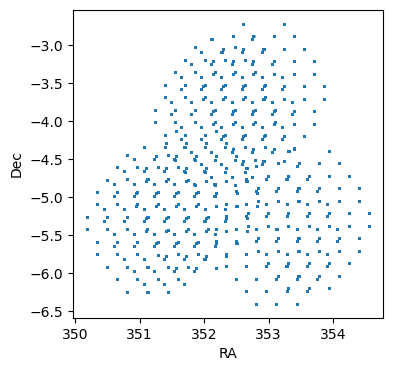

In [69]:
%%time
# Let us visualize where on the sky our chip centers reside
fig = plt.figure(figsize=(4, 4))
plt.xlabel("RA")
plt.ylabel("Dec")
plt.scatter(
    [i[0] for i in df["center_coord"].iloc()], [i[1] for i in df["center_coord"].iloc()], s=1, alpha=0.5
)

The DECam mosaic shape is clearly visible, thrice.\
There is an offset from each of the three pointings, too.

In the most simple approach, each of these "dots" represents a set of images that can be fed to KBMOD.

In [70]:
# look at the first dataId, which does not show up in a pretty way in the DF
df["data_id"].iloc[0]

{'instrument': 'DECam', 'detector': 1, 'visit': 898286}

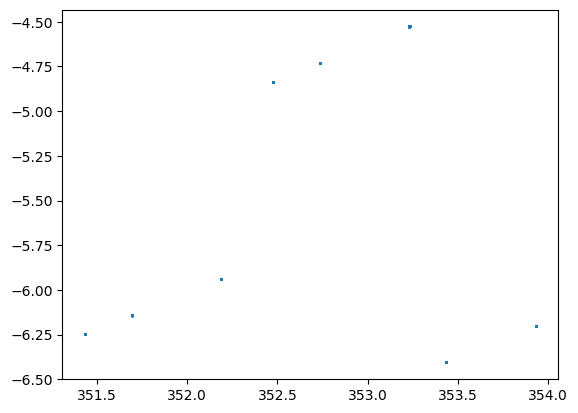

In [71]:
# Let us look at just detector 62 pointings.
# This will give us a decent idea of how many pointings there are (here, 8).

df62 = df[df["detector"] == 62]
plt.clf()
plt.scatter(*zip(*df62["center_coord"]), s=1, alpha=0.5)

In [72]:
# chip62_coord0 = df62['center_coord'][0]

### Region Matching
Here region matching means comparing two lsst.sphgeom.region objects.\
Purpose: to see if they have any overlap whatsoever. \
NOTE: a partial or full overlap is called an "intersection" in sphgeom lingo.

NOTE: Work in progress, but pausing this avenue for now. 2/2/2024 COC

In [73]:
# manual region-region matching between all chips
# NOTE: estimate time is 1 hour, so skipping this for now

doit = False
if doit == True:
    lastTime = time.time()

    matches = {}

    with progressbar.ProgressBar(max_value=len(vdr_regions)) as bar:
        for i, l in enumerate(vdr_regions):
            my_id = vdr_ids[i]
            matches[my_id] = []
            for j, r in enumerate(vdr_regions):
                if i == j:
                    continue
                if l.intersects(r):
                    matches[my_id].append(vdr_ids[j])
            bar.update(i)
    elapsed = round(time.time() - lastTime, 1)
    print(f"It took {elapsed} seconds.")

To be continued...

### HTM Exploration

In [74]:
# Colin playing 1/15/2024 COC
def getHTMstuff(ra, dec, level=7, verbose=False):
    """
    1/16/2024 COC inception.
    A function that
        1. Fetches an HTM ID for a pixelization of a user-supplied level.
        2. Determines the angular size (radius, in arcseconds) of the pixelization level.
    LSST stores the unique HTM ID for level 7 pixelization in the Butler, hence the default level=7.
    """
    pixelization = lsst.sphgeom.HtmPixelization(level)

    try:  # kludges; use the Butler way, but if being passed normal numbers, use those
        ra = ra.asDegrees()
    except AttributeError as msg:
        pass
    try:
        dec = dec.asDegrees()
    except AttributeError as msg:
        pass

    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            # sphgeom.LonLat.fromDegrees(ra.asDegrees(), dec.asDegrees())
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees() * 3600.0
    level = pixelization.getLevel()
    if verbose:
        print(f"HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.")
    return (htm_id, scale)

In [75]:
getHTMstuff(df["center_coord"].iloc()[0][0], df["center_coord"].iloc()[0][1], verbose=True)

HTM ID=189361 at level=7 is bounded by a circle of radius ~1895.11 arcsec.


(189361, 1895.111766130883)

In [76]:
dsRefs = butler.registry.queryDatasets(
    datasetType=desired_datasetTypes[0], htm7=147116, collections=desired_collections
)
print(len(sorted(dsRefs)))

0


To be continued...

### Brute force approach for (small) discrete datasets

The idea here is that we can organize discrete piles of images, such as DEEP, DDF.

In [77]:
def find_overlapping_coords(df, uncertainty_radius, overwrite=False):
    """

    Added caching 2/5/2024 COC
    """
    cache_file = f"{basedir}/overlapping_sets.pickle"

    cache_exists = False
    if len(glob.glob(cache_file)) > 0:
        cache_exists = True

    if overwrite == False and cache_exists == True:
        with open(cache_file, "rb") as f:
            print(f"Recycling {cache_file} as overwrite={overwrite}.")
            overlapping_sets = pickle.load(f)
            return overlapping_sets

    df_copy = df.copy()

    # Assuming uncertainty_radius is provided as a float in arcseconds
    uncertainty_radius_as = uncertainty_radius * u.arcsec

    all_coords = SkyCoord(
        ra=[x[0] for x in df_copy["center_coord"]] * u.degree,
        dec=[x[1] for x in df_copy["center_coord"]] * u.degree,
    )

    overlapping_sets = {}
    set_counter = 1
    processed_data_ids = []

    periodic_update_counter = 0
    with progressbar.ProgressBar(max_value=len(all_coords)) as bar:
        for index, coord in enumerate(all_coords):
            data_id = df_copy.iloc[index]["data_id"]
            if data_id not in processed_data_ids:
                distances = (
                    coord.separation(all_coords).to(u.arcsec).value
                )  # Convert distances to arcseconds as numeric values

                # Perform comparison as numeric values, bypassing direct unit comparison
                within_radius = (distances <= uncertainty_radius_as.value) & (distances > 0)

                if any(within_radius):
                    overlapping_indices = [
                        i
                        for i, distance in enumerate(distances)
                        if (distance <= uncertainty_radius_as.value) and i != index
                    ]
                    overlapping_data_ids = df_copy.iloc[overlapping_indices]["data_id"].tolist()
                    overlapping_data_ids.append(data_id)

                    processed_data_ids.extend(overlapping_data_ids)

                    overlapping_sets[f"set_{set_counter}"] = overlapping_data_ids
                    set_counter += 1
            #
            # mitigate too much output 2/5/2024 COC
            periodic_update_counter += 1
            if periodic_update_counter >= 250:
                periodic_update_counter = 0
                bar.update(index)

    with open(cache_file, "wb") as f:
        pickle.dump(overlapping_sets, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Saved overlapping_sets to {cache_file} for caching purposes.")

    return overlapping_sets

In [78]:
%%time

# TIMING NOTE: this takes about 1.25 hours [TODO update that number]
# TODO test caching

overlapping_sets = find_overlapping_coords(df=df, uncertainty_radius=30, overwrite=False)

Recycling /astro/users/coc123/kbmod_tmp/overlapping_sets.pickle as overwrite=False.
CPU times: user 263 ms, sys: 31.5 ms, total: 295 ms
Wall time: 293 ms


In [79]:
print(f"There are {len(overlapping_sets.keys())} discrete chip-level pointings.")  # should be 488

There are 488 discrete chip-level pointings.


#### Exploring the overlapping_sets

In [80]:
# Create lookup tables for data_id_str to center_coord and ut_datetime for vast speed-ups.
id_to_coord = df.set_index("data_id_str")["center_coord"].to_dict()
id_to_date = df.set_index("data_id_str")["ut_datetime"].dt.date.to_dict()

CPU times: user 26.4 ms, sys: 4.71 ms, total: 31.1 ms
Wall time: 29.1 ms


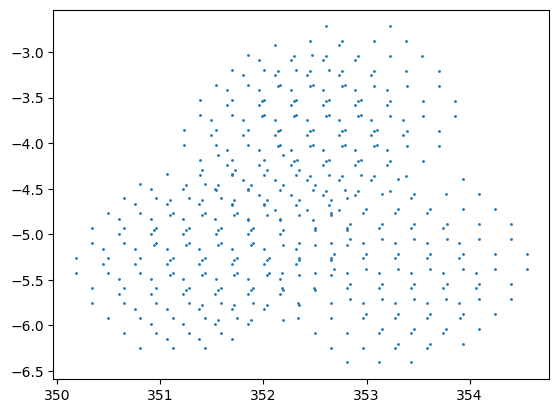

In [81]:
%%time
# Looking at the processed data.

# Preparing for bulk plotting (if every point uses the same label, adjust as needed)
coords = [id_to_coord[dataId_to_dataIdStr(overlapping_sets[p][0])] for p in overlapping_sets]
x_coords, y_coords = zip(*coords)  # Assuming coords are tuples or lists

# Plotting in bulk
plt.scatter(x_coords, y_coords, s=1)

<timed exec>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


CPU times: user 5.5 s, sys: 532 ms, total: 6.03 s
Wall time: 5.48 s


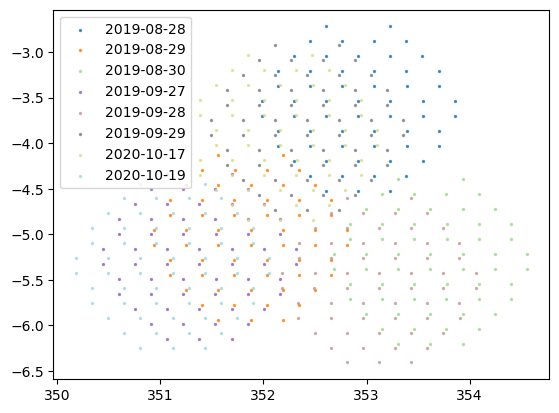

In [82]:
%%time

# TIMING NOTE: this requires about 7 seconds

# Extract unique dates and create a color map
unique_dates = sorted(set(id_to_date.values()))
date_to_color = {date: i for i, date in enumerate(unique_dates)}
norm = Normalize(vmin=0, vmax=len(unique_dates) - 1)
cmap = get_cmap("tab20", len(unique_dates))  # Choose a colormap that fits the data

# Preparing data for plotting
coords = [id_to_coord[dataId_to_dataIdStr(overlapping_sets[p][0])] for p in overlapping_sets]
dates = [id_to_date[dataId_to_dataIdStr(overlapping_sets[p][0])] for p in overlapping_sets]
colors = [cmap(norm(date_to_color[date])) for date in dates]

# Plotting
lcount = 0
for (x, y), color, date in zip(coords, colors, dates):
    lcount += 1
    plt.scatter(x, y, color=color, label=date.strftime("%Y-%m-%d"), alpha=0.75, s=2)

# To avoid duplicate labels in the legend, handle legend entries manually
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removing duplicates

current_handles, current_labels = plt.gca().get_legend_handles_labels()

current_handles = list(by_label.values())
current_labels = list(by_label.keys())
# sort or reorder the labels and handles
sorted_ix = sorted(range(len(current_labels)), key=lambda k: current_labels[k])
sorted_handles = [current_handles[i] for i in sorted_ix]  # list(current_handles)
sorted_labels = [current_labels[i] for i in sorted_ix]  # list(current_labels)

# call plt.legend() with the new values
plt.legend(sorted_handles, sorted_labels)

# plt.legend(by_label.values(), by_label.keys())
plt.savefig(f"{basedir}/pointings.pdf")

In [83]:
# Here are the unique dates found in the discrete dataset
unique_dates = sorted(set(id_to_date.values()))
print("\n".join([str(dt) for dt in unique_dates]))

2019-08-28
2019-08-29
2019-08-30
2019-09-27
2019-09-28
2019-09-29
2020-10-17
2020-10-19


##### Double-checking a single date

In [84]:
df.iloc()[0]

data_id         {'instrument': 'DECam', 'detector': 1, 'visit'...
region          ConvexPolygon([UnitVector3d(0.9847372525065534...
detector                                                        1
data_id_str                                        DECam_1_898286
uri             file:///epyc/users/smotherh/DEEP/PointingGroup...
ut                                        2019-09-27T00:20:22.932
ut_datetime                            2019-09-27 00:20:22.932000
center_coord              (351.0694028401149, -4.336598368890197)
Name: 0, dtype: object

In [85]:
id_to_date[dataId_to_dataIdStr(df["data_id"].iloc()[0])]

datetime.date(2019, 9, 27)

In [86]:
id_to_coord[dataId_to_dataIdStr(df["data_id"].iloc()[0])]

(351.0694028401149, -4.336598368890197)

In [87]:
# We will make a dataframe with just the date we are checking
df20190828 = df[df["ut_datetime"].dt.date == parser.parse("2019-08-28").date()]
len(df20190828)

6267

CPU times: user 954 ms, sys: 14.5 ms, total: 969 ms
Wall time: 968 ms


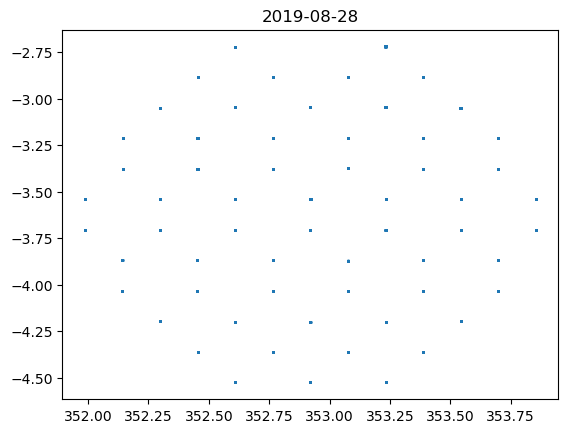

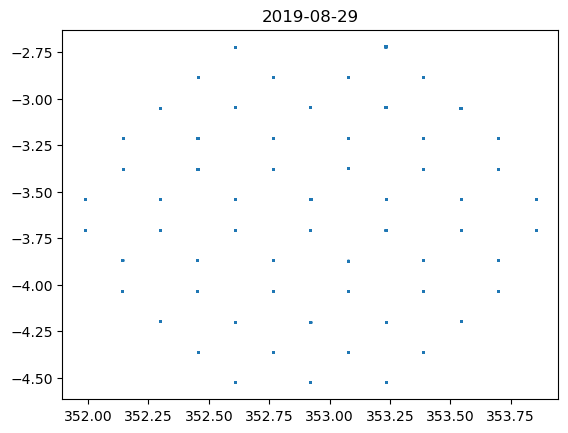

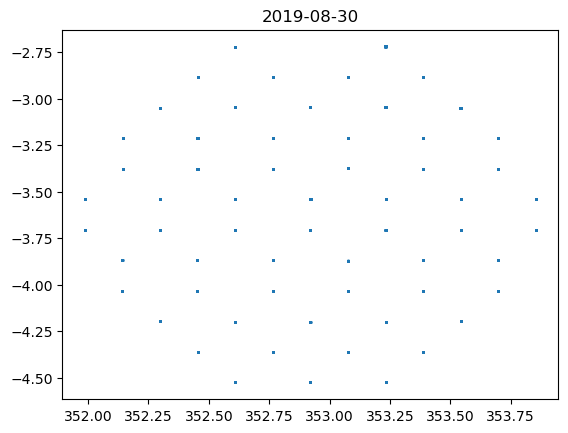

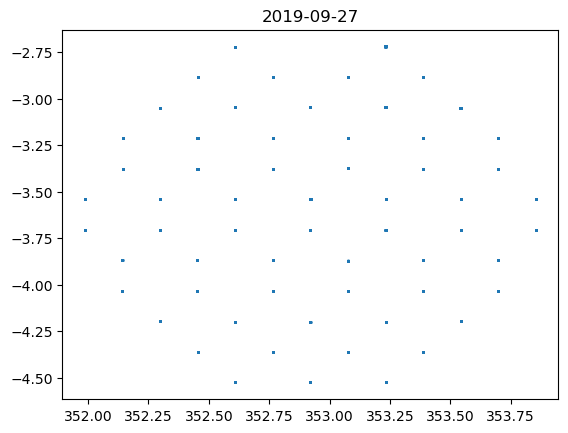

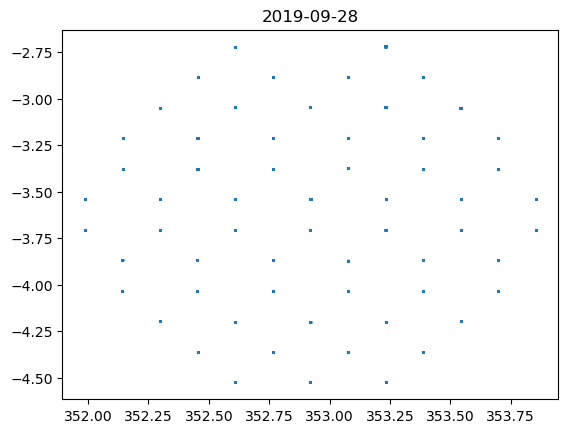

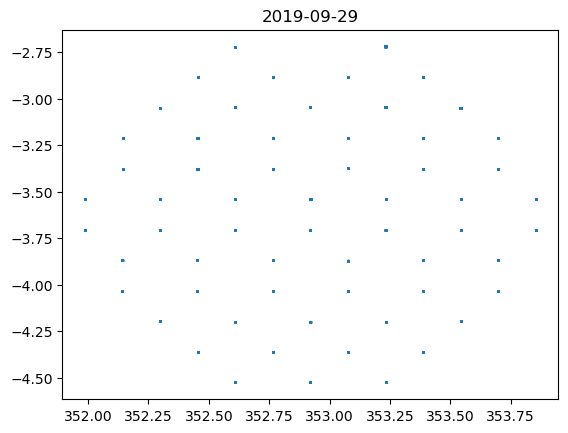

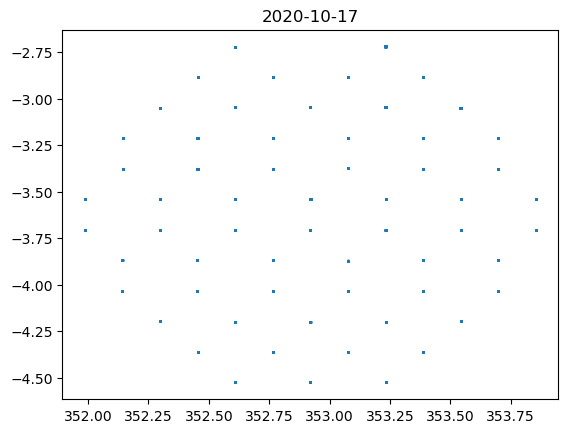

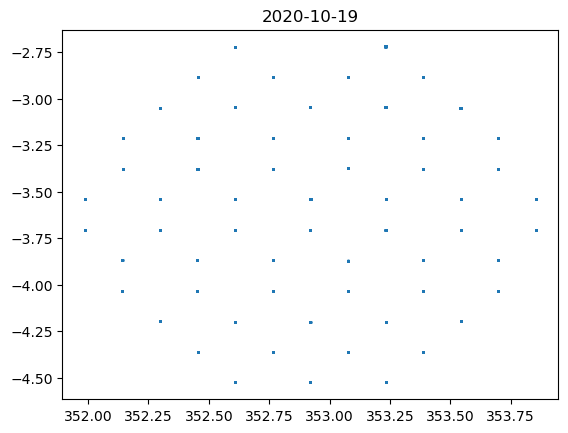

In [88]:
%%time
# Visualize all of the unique dates, one at a time.
for dt in unique_dates:
    fig = plt.figure()
    tmpdf = df[df["ut_datetime"].dt.date == parser.parse("2019-08-28").date()]
    plt.scatter(*zip(*tmpdf["center_coord"]), s=1, alpha=0.5)
    plt.title(f"{dt}")
del tmpdf

In [89]:
# Exploring some timespan considerations 4/18/2024
#
# Note: in this repository ("Hayden DEEP") there are no multi-date overlaps.
# ... thus, we will need to revisit this with the broader "Steven DEEP" repository. 4/23/2024 COC
overlapping_sets
for overlapping_set in overlapping_sets:
    dates = [id_to_date[dataId_to_dataIdStr(i)] for i in overlapping_sets[overlapping_set]]
    unique_dates = list(set(dates))
    unique_dates.sort()
    if len(unique_dates) < 2:
        print(f"Skipping {overlapping_set} because only one date.")
        continue
    counts = [dates.count(i) for i in unique_dates]
    plt.plot_date(unique_dates, counts)
    break

Skipping set_1 because only one date.
Skipping set_2 because only one date.
Skipping set_3 because only one date.
Skipping set_4 because only one date.
Skipping set_5 because only one date.
Skipping set_6 because only one date.
Skipping set_7 because only one date.
Skipping set_8 because only one date.
Skipping set_9 because only one date.
Skipping set_10 because only one date.
Skipping set_11 because only one date.
Skipping set_12 because only one date.
Skipping set_13 because only one date.
Skipping set_14 because only one date.
Skipping set_15 because only one date.
Skipping set_16 because only one date.
Skipping set_17 because only one date.
Skipping set_18 because only one date.
Skipping set_19 because only one date.
Skipping set_20 because only one date.
Skipping set_21 because only one date.
Skipping set_22 because only one date.
Skipping set_23 because only one date.
Skipping set_24 because only one date.
Skipping set_25 because only one date.
Skipping set_26 because only one d

### (RA, Dec) searching of image sets

In [90]:
# Fetch an (RA, Dec) pair from an image set.
first_set_name = list(overlapping_sets.keys())[0]
first_sets_data_id = overlapping_sets[first_set_name][0]
searching_ra_dec = df.set_index("data_id_str")["center_coord"].to_dict()[
    dataId_to_dataIdStr(first_sets_data_id)
]

print(f'"{first_set_name}" is the first set name in overlapping_sets.')
print(f"Its first record dataId: {first_sets_data_id}.")
print(f"It has an (RA, Dec) coordinate of {searching_ra_dec}.")

"set_1" is the first set name in overlapping_sets.
Its first record dataId: {instrument: 'DECam', detector: 1, visit: 898287}.
It has an (RA, Dec) coordinate of (351.0695696334572, -4.336293374423113).


In [91]:
def ra_dec_search_overlapping_sets(df, overlapping_sets, ra_dec, search_radius, verbose=False):
    """
    2/6/2024 COC
    Implementing an extremely basic (RA, Dec) query functionality.
    This will work within the overlapping_sets framework.
    """
    ra_dec_coord = SkyCoord(ra=ra_dec[0] * u.degree, dec=ra_dec[1] * u.degree)

    all_centers = []
    all_labels = []

    # id_to_coord = df.set_index("data_id_str")["center_coord"].to_dict() # note this was generated already but outside the function

    for i, set_name in enumerate(list(overlapping_sets.keys())):
        all_labels.append(set_name)
        center_data_id = overlapping_sets[set_name][0]
        center_coord = id_to_coord[dataId_to_dataIdStr(center_data_id)]
        all_centers.append(center_coord)

    all_centers = SkyCoord(
        ra=[x[0] for x in all_centers] * u.degree,
        dec=[x[1] for x in all_centers] * u.degree,
    )

    distances = ra_dec_coord.separation(all_centers)
    within_radius = (distances <= search_radius) & (
        distances >= 0
    )  # ≥ (not >) because we could supply the an exact match

    results = []
    for i, item in enumerate(within_radius):
        if item == True:
            results.append(all_labels[i])
    if verbose:
        print(f"We found {len(results)} sets that are within {search_radius} of {ra_dec}.")
    return results

In [92]:
# Find matching image sets.
# With 1*u.arcminute we would only find set_1 (where we got searching_ra_dec).
# With 15*u.arcminute, we find 3 others (for a total of 4).
search_radius = 14 * u.arcminute
ra_dec_search_results = ra_dec_search_overlapping_sets(
    df=df,
    overlapping_sets=overlapping_sets,
    ra_dec=searching_ra_dec,
    search_radius=search_radius,
    verbose=True,
)
ra_dec_search_results

We found 4 sets that are within 14.0 arcmin of (351.0695696334572, -4.336293374423113).


['set_1', 'set_3', 'set_4', 'set_68']

[[(350.9194972863569, -4.410893881734765), (350.9194972863569, -4.261692867111463), (351.2196419805575, -4.410893881734765), (351.2196419805575, -4.261692867111463)], [(350.7636367448476, -4.57504777569875), (350.7636367448476, -4.425558984666654), (351.06385253666514, -4.57504777569875), (351.06385253666514, -4.425558984666654)], [(351.07489718950103, -4.574714132229647), (351.07489718950103, -4.425184883190398), (351.3752749096747, -4.574714132229647), (351.3752749096747, -4.425184883190398)], [(351.1044786505892, -4.535445547532834), (351.1044786505892, -4.385657669534001), (351.40443040247294, -4.535445547532834), (351.40443040247294, -4.385657669534001)]]


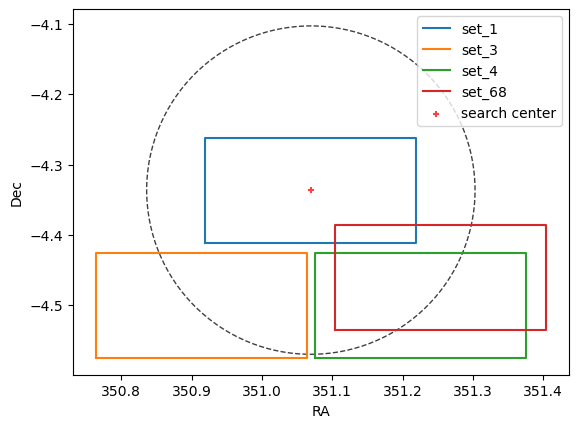

In [93]:
matching_regions = []
id_to_region = df.set_index("data_id_str")["region"].to_dict()

for set_name in ra_dec_search_results:
    matching_regions.append(id_to_region[dataId_to_dataIdStr(overlapping_sets[set_name][0])])

all_corners = [getRegionCorners(region) for region in matching_regions]
print(all_corners)

for i, quad in enumerate(all_corners):
    ra_bounds, dec_bounds = getMinMaxRaDec(quad)
    #
    coords = []
    coords.append((ra_bounds[0], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[0]))  # close the "shape"
    #
    plt.plot([x[0] for x in coords], [x[1] for x in coords], label=ra_dec_search_results[i])

plt.scatter(
    searching_ra_dec[0],
    searching_ra_dec[1],
    s=25,
    marker="+",
    alpha=0.75,
    label=f"search center",
    color="red",
)
circle = plt.Circle(
    (searching_ra_dec[0], searching_ra_dec[1]),
    search_radius.to(u.degree).value,
    color="black",
    alpha=0.75,
    fill=False,
    label="search area",
    linestyle="--",
)
plt.legend()
plt.xlabel(f"RA")
plt.ylabel("Dec")
ax = plt.gca()
ax.add_patch(circle)
ax.set_aspect("equal", adjustable="box")

### (RA, Dec) searching of our DataFrame (more general case)
It is far faster to search overlapping_sets as there are few of these to inspect.
A more general case, however, would be to simply find all images within a radius of a sky coordinate.

In [94]:
def ra_dec_search_df(df, ra_dec, search_radius, verbose=False):
    """
    2/6/2024 COC
    Implementing a basic (RA, Dec) query function for our derived Pandas dataframe.
    """

    ra_dec_coord = SkyCoord(ra=ra_dec[0] * u.degree, dec=ra_dec[1] * u.degree)

    all_centers = SkyCoord(
        ra=[x[0] for x in df["center_coord"].iloc()] * u.degree,
        dec=[x[1] for x in df["center_coord"].iloc()] * u.degree,
    )

    distances = ra_dec_coord.separation(all_centers)
    within_radius = (distances <= search_radius) & (
        distances >= 0
    )  # ≥ (not >) because we could supply the an exact match

    results = df[within_radius]

    if verbose:
        print(f"We found {len(results.index)} matches within {search_radius} of {ra_dec}.")
    return results

In [95]:
%%time
ra_dec_search_radius = 3 * u.arcsec
ra_dec_search_results_df = ra_dec_search_df(
    df=df, ra_dec=searching_ra_dec, search_radius=ra_dec_search_radius, verbose=True
)
ra_dec_search_results_df

We found 95 matches within 3.0 arcsec of (351.0695696334572, -4.336293374423113).
CPU times: user 2.88 s, sys: 23.5 ms, total: 2.9 s
Wall time: 2.9 s


,data_id,region,detector,data_id_str,uri,ut,ut_datetime,center_coord
0,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847372525065534...,1,DECam_1_898286,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:20:22.932,2019-09-27 00:20:22.932,"(351.0694028401149, -4.336598368890197)"
1,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847381014554984...,1,DECam_1_898287,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:22:51.015,2019-09-27 00:22:51.015,"(351.0695696334572, -4.336293374423113)"
2,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847383417970056...,1,DECam_1_898288,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:25:19.136,2019-09-27 00:25:19.136,"(351.0696571334576, -4.336293374415341)"
3,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847382159041213...,1,DECam_1_898289,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:27:47.118,2019-09-27 00:27:47.118,"(351.069611300124, -4.336293374419411)"
4,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847381374341414...,1,DECam_1_898290,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:30:15.537,2019-09-27 00:30:15.537,"(351.0695696451088, -4.336265319377865)"
...,...,...,...,...,...,...,...,...
90,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847391753851408...,1,DECam_1_898376,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:02:58.424,2019-09-27 04:02:58.424,"(351.06998627728365, -4.3363483733857136)"
91,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847400909178194...,1,DECam_1_898377,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:05:27.654,2019-09-27 04:05:27.654,"(351.0703196106188, -4.336348373356122)"
92,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847397935953284...,1,DECam_1_898378,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:07:56.159,2019-09-27 04:07:56.159,"(351.07019878847524, -4.336321429412502)"
93,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847392459182945...,1,DECam_1_898379,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:10:25.141,2019-09-27 04:10:25.141,"(351.069986300126, -4.336293374386118)"


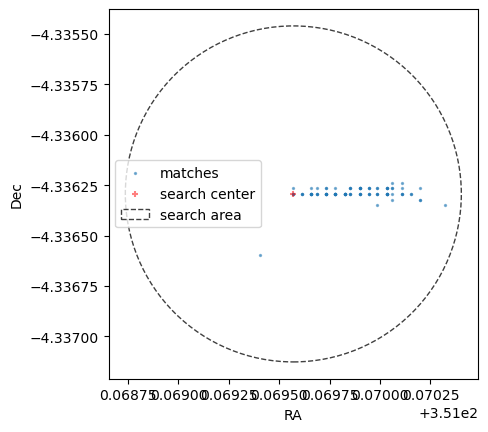

In [96]:
# Plot the centers
plt.scatter(
    [x[0] for x in ra_dec_search_results_df["center_coord"]],
    [x[1] for x in ra_dec_search_results_df["center_coord"]],
    s=2,
    alpha=0.5,
    label="matches",
)

plt.scatter(
    searching_ra_dec[0], searching_ra_dec[1], color="red", s=20, alpha=0.5, marker="+", label="search center"
)

circle = plt.Circle(
    (searching_ra_dec[0], searching_ra_dec[1]),
    ra_dec_search_radius.to(u.degree).value,
    color="black",
    alpha=0.75,
    fill=False,
    label="search area",
    linestyle="--",
)

plt.xlabel(f"RA")
plt.ylabel("Dec")
ax = plt.gca()
ax.add_patch(circle)
plt.legend()
ax.set_aspect("equal", adjustable="box")

# TODO consider making this dRA, dDec from minimum (RA, Dec) values 4/23/2024 COC

These are the 95 matching center coordinates.\
These may look far off, but this is just the scale.\
We can plot the entire chip area on-sky, as we did earlier overlapping_sets.

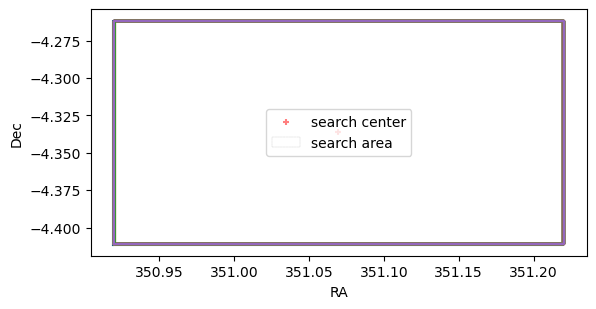

In [97]:
# Plot the centers
# plt.scatter([x[0] for x in ra_dec_search_results_df["center_coord"]], [x[1] for x in ra_dec_search_results_df["center_coord"]], s=2, alpha=0.5, label="matches")
plt.scatter(
    searching_ra_dec[0], searching_ra_dec[1], color="red", s=20, alpha=0.5, marker="+", label="search center"
)

for quad in [getRegionCorners(x) for x in ra_dec_search_results_df["region"]]:
    ra_bounds, dec_bounds = getMinMaxRaDec(quad)
    #
    coords = []
    coords.append((ra_bounds[0], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[0]))  # close the "shape"
    #
    plt.plot([x[0] for x in coords], [x[1] for x in coords]),  # label=ra_dec_search_results[i])

circle = plt.Circle(
    (searching_ra_dec[0], searching_ra_dec[1]),
    ra_dec_search_radius.to(u.degree).value,
    color="black",
    alpha=0.75,
    fill=False,
    label="search area",
    linestyle="--",
    linewidth=0.1,
)

plt.xlabel(f"RA")
plt.ylabel("Dec")
ax = plt.gca()
ax.add_patch(circle)
plt.legend()
ax.set_aspect("equal", adjustable="box")

# Recap and Master Functions
Here is a master function that takes a repo_path and returns \
(1) a Pandas dataframe with needed info, and\
(2) a dictionary with the images in discrete piles (sets).

In [98]:
def retrieve_image_sets(
    repo_path,
    basedir="default",
    desired_datasetTypes=["deepDiff_differenceExp"],
    overwrite=False,
    overlap_uncertainty_radius_arcsec=30,
):
    """
    2/6/2024 COC
    """
    if basedir == "default":
        basedir = f'{os.environ["HOME"]}/kbmod_tmp'
        print(f'Changing "default" basedir to {basedir} now.')

    os.makedirs(basedir, exist_ok=True)

    #     repo_path = f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
    butler = dafButler.Butler(repo_path)

    all_collection_names = get_collection_names(butler=butler, basedir=basedir, verbose=True, export=True)
    desired_collections = get_desired_collections(all_collections_list=all_collection_names)
    #     datasetTypes = getDatasetTypeStats(butler=butler, overwrite=False) # not used 2/6/2024 COC
    #     desired_datasetTypes = ["deepDiff_differenceExp"]
    df, example_vdr_ref = get_vdr_data(
        butler=butler, desired_collections=desired_collections, desired_datasetTypes=desired_datasetTypes
    )
    desired_instruments = getInstruments(butler=butler, vdr_ids=df["data_id"])
    df["center_coord"] = [getCenterRaDec(i) for i in df["region"]]
    df["uri"] = getURIs(
        butler=butler,
        dataIds=df["data_id"],
        repo_path=repo_path,
        desired_datasetTypes=desired_datasetTypes,
        desired_collections=desired_collections,
        overwrite=overwrite,
    )

    df["ut"] = getTimestamps(dataIds=df["data_id"], overwrite=overwrite)
    df["ut_datetime"] = pd.to_datetime(df["ut"])
    overlapping_sets = find_overlapping_coords(
        df=df, uncertainty_radius=overlap_uncertainty_radius_arcsec, overwrite=overwrite
    )
    return df, overlapping_sets

In [99]:
%%time

# Example
# TIMING NOTE: this requires about 7 seconds to run ***with everything already cached***.
df1, overlapping_sets1 = retrieve_image_sets(
    repo_path=f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
)

Changing "default" basedir to /astro/users/coc123/kbmod_tmp now.
Found 1292 collections in the Butler. Wrote to "/astro/users/coc123/kbmod_tmp/all_collection_names.lst".
Found DECam. Adding to "desired_instruments" now.
Recycled 47383 paths from /astro/users/coc123/kbmod_tmp/uri_cache.lst as overwrite was False.
Overwrite is False, so we will read the timestamps from file now...
Recycled 47383 from /astro/users/coc123/kbmod_tmp/vdr_timestamps.lst.
Recycling /astro/users/coc123/kbmod_tmp/overlapping_sets.pickle as overwrite=False.
CPU times: user 4.84 s, sys: 443 ms, total: 5.28 s
Wall time: 6.6 s


The other high-level function is searching the overlapping sets for a specific (RA, Dec) coordinate.

In [100]:
ra_dec_search_results1 = ra_dec_search_overlapping_sets(
    df=df1,
    overlapping_sets=overlapping_sets1,
    ra_dec=(351.0695696334572, -4.336293374423113),
    search_radius=15 * u.arcminute,
    verbose=True,
)
ra_dec_search_results1

We found 4 sets that are within 15.0 arcmin of (351.0695696334572, -4.336293374423113).


['set_1', 'set_3', 'set_4', 'set_68']

In [101]:
ra_dec_search_results2 = ra_dec_search_df(
    df=df, ra_dec=(351.0695696334572, -4.336293374423113), search_radius=3 * u.arcsec, verbose=True
)
ra_dec_search_results2

We found 95 matches within 3.0 arcsec of (351.0695696334572, -4.336293374423113).


,data_id,region,detector,data_id_str,uri,ut,ut_datetime,center_coord
0,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847372525065534...,1,DECam_1_898286,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:20:22.932,2019-09-27 00:20:22.932,"(351.0694028401149, -4.336598368890197)"
1,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847381014554984...,1,DECam_1_898287,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:22:51.015,2019-09-27 00:22:51.015,"(351.0695696334572, -4.336293374423113)"
2,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847383417970056...,1,DECam_1_898288,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:25:19.136,2019-09-27 00:25:19.136,"(351.0696571334576, -4.336293374415341)"
3,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847382159041213...,1,DECam_1_898289,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:27:47.118,2019-09-27 00:27:47.118,"(351.069611300124, -4.336293374419411)"
4,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847381374341414...,1,DECam_1_898290,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:30:15.537,2019-09-27 00:30:15.537,"(351.0695696451088, -4.336265319377865)"
...,...,...,...,...,...,...,...,...
90,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847391753851408...,1,DECam_1_898376,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:02:58.424,2019-09-27 04:02:58.424,"(351.06998627728365, -4.3363483733857136)"
91,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847400909178194...,1,DECam_1_898377,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:05:27.654,2019-09-27 04:05:27.654,"(351.0703196106188, -4.336348373356122)"
92,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847397935953284...,1,DECam_1_898378,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:07:56.159,2019-09-27 04:07:56.159,"(351.07019878847524, -4.336321429412502)"
93,"{'instrument': 'DECam', 'detector': 1, 'visit'...",ConvexPolygon([UnitVector3d(0.9847392459182945...,1,DECam_1_898379,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:10:25.141,2019-09-27 04:10:25.141,"(351.069986300126, -4.336293374386118)"


### Sky Patches
For datasets spanning large spatial areas, such as LSST, we need a different approach.\
We will uniformly divide the sky into "patches" of the sky.\
We will also give an option to have the patches overlap by some percentage.\
Patches can primarily be used in three ways:\
1. Their center (RA, Dec) coordinate.
2. The "corner" (RA, Dec) coordinates. Corners are really vertices of quadrilateral patches.
3. A LSST Sphgeom region, which may be hashed.

In [102]:
# First we introduce our patch generator.


def generate_patches(arcminutes, overlap_percentage, verbose=True, decRange=[-90, 90], export=False):
    """Given a "rectangle" in (RA, Dec) touple (probably based on some chip size),
    produce a list of bounded regions on the sky,
    with user-supplied edge overlap percentage (overlap_percentage).
    The list is to be iterated over when matching against actual observations,
    i.e., for later shift-and-stack.
    v0: 12/11/2023 COC
    Note: this all assumes small angle approximation is OK. 1/9/2024 COC
    TODO: something to limit Dec range (min or max).
        E.g., at LSST (30.241° S) they cannot see anything above 59.759° N.
    """
    import numpy as np

    def checkDec(n):
        if n > 90:
            n -= 180
        elif n < -90:
            n += 180
        return n

    def checkRA(n):
        if n > 360:
            n -= 360
        if n < 0:
            n += 360
        return n

    # Convert arcminutes to degrees (work base unit)
    arcdegrees = np.array(arcminutes) / 60.0

    # Calculate overlap in degrees
    overlap = arcdegrees * (overlap_percentage / 100.0)

    # Number of patches needed in RA, Dec space
    # TODO: consider these aren't decimal; so should be ceil for bounds 1/9/2024 COC
    num_patches_ra = int(360 / (arcdegrees[0] - overlap[0]))
    num_patches_dec = int(180 / (arcdegrees[1] - overlap[1]))
    if verbose:
        print(
            f"Number of patches in (RA, Dec): ({num_patches_ra},{num_patches_dec})."
        )  # Recall (RA, Dec) ranges are (0-360,0-180), so square inputs result in (n*2, n) ranges.

    # Generate patches
    patches = []
    centers = []  # 1/15/2024 COC
    skippedBecauseOfDec = 0
    for ra_index in range(num_patches_ra):
        # Calculate corner RA coordinates; moved out of dec loop 1/11/2024 COC
        ra_start = checkRA(ra_index * (arcdegrees[0] - overlap[0]))
        center_ra = checkRA(ra_start + arcdegrees[0] / 2)  # 1/15/2024 COC
        ra_end = checkRA(ra_start + arcdegrees[0])
        #
        for dec_index in range(num_patches_dec):
            # Calculate corner Dec coordinates
            dec_start = checkDec(dec_index * (arcdegrees[1] - overlap[1]) - 90)
            center_dec = checkDec(dec_start + arcdegrees[1] / 2)  # 1/15/2024 COC
            dec_end = checkDec(dec_start + arcdegrees[1])
            #
            # Make sure Dec is in allowed range; KLUDGE 1/9/2024 COC
            OK = True
            for d in [dec_start, dec_end]:
                if d < decRange[0] or d > decRange[1]:
                    OK = False
                    break
            if OK == False:
                skippedBecauseOfDec += 1
                #                 print(f'Something is outside of valid Dec range: dec_start={dec_start}, dec_end={dec_end}')
                continue
            #
            # Append patch coordinates to the list
            patches.append(((ra_start, dec_start), (ra_end, dec_end)))
            centers.append((center_ra, center_dec))  # 1/15/2024 COC

    #
    npatches = len(patches)
    info = {"npatches": npatches, "arcminutes": arcminutes, "overlap": overlap_percentage}
    if verbose:
        print(
            f"There were {npatches} produced, skipping {skippedBecauseOfDec} because Dec was outside {decRange}. Info: {info}."
        )
    #
    # produce CSV if desired
    if export == True:
        outfile = f"patches_{arcminutes[0]}x{arcminutes[1]}arcmin_{overlap_percentage}pctOverlap"
        if decRange != None:
            outfile += f"_Dec{decRange[0]}to{decRange[1]}"
        outfile += ".csv"
        with open(outfile, "w") as f:
            print(f"ra0,dec0,ra1,dec1", file=f)
            for quad in patches:
                print(f"{quad[0][0]},{quad[0][1]},{quad[1][0]},{quad[1][1]}", file=f)
            print(f"Wrote {len(patches)} patch rows to {outfile}.")
    #
    return patches, centers, info

In [103]:
# Let's start by generating 1°X1° (one degree square) patches, with no overlap.
# This should be the number of degrees in the range of RA (0 to 360 = 360) * the range in Dec (-90 to 90 = 180.)
# 360 * 180 = 64,800 square degrees.
# (We know a priori that this should be around 41,253 square degrees,
# but our grid is of small angles and does not take into account spherical geometry.)

tmp = generate_patches(arcminutes=(1 * 60, 1 * 60), overlap_percentage=0)

Number of patches in (RA, Dec): (360,180).
There were 64800 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 64800, 'arcminutes': (60, 60), 'overlap': 0}.


In [104]:
# The numbers go up dramatically when we introduce even a small-ish overlap. Let's try 10%.
tmp = generate_patches(arcminutes=(1 * 60, 1 * 60), overlap_percentage=10)

Number of patches in (RA, Dec): (400,200).
There were 80000 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 80000, 'arcminutes': (60, 60), 'overlap': 10}.


In [105]:
# Let's consider a single slice along Right Ascension, keeping Declination constant at 0.25° = 15'.
# This is roughly one LSST chip FOV.
tmp = generate_patches(arcminutes=(15, 15), overlap_percentage=0, decRange=[0, 0.25])

Number of patches in (RA, Dec): (1440,720).
There were 1440 produced, skipping 1035360 because Dec was outside [0, 0.25]. Info: {'npatches': 1440, 'arcminutes': (15, 15), 'overlap': 0}.


In [106]:
# How many is this, compared to the Hayden DEEP set?
print(
    f'There are {round(tmp[2]["npatches"]/len(overlapping_sets),2)} times more chip fields in one Dec slice than all of DEEP.'
)
tmp[2]["npatches"]

There are 2.95 times more chip fields in one Dec slice than all of DEEP.


1440

In [107]:
# Ground-based observatories cannot see all of the Celestial Sphere because Earth gets in the way.
# The farthest hypothetical dec observable from a given latitude is:
#     (observer latitude) - 90° (in the North)
#     (observer latitude) + 90° (in the South)
# The key fun fact is that observer latitude = elevation of the corresponding (N or S) celestial pole.
#
# Examples:
# North Pole, latitude +90°: +90° - 90° = 0°
# South Pole, latitude -90°: -90° + 90° = 0°
# Equator, latitude ±0°: 0° ±90° = ±90°.
# LSST, latitude -30.1732°: -30.1732° + 90° = 59.8268°.
#
# Note: this is the geometric limit, but in practice
# (a) the horizon is rarely unobstructed/flat
# (b) telescopes cannot (or will not) point anywhere near the horizon
#
# Given (b) above, it would be optimal to further offset the dec range for a telescope's stated lower elevation (altitude) limit.

In [108]:
# Here we have a function to visualize the patches we are generating.
def plot_patches(
    patches, limit=None, xrange=[0, 360], yrange=[-90, 90], title=None, subfolder=".", export=False
):
    """
    Plot the patches provided by generate_patches(), with options for visualization.
    2/15/2024 COC updated
    """
    import os

    os.makedirs(subfolder, exist_ok=True)
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    patch_count = len(patches)
    print(f"There are {patch_count} to plot.")
    fig, ax = plt.subplots()
    colors = ["blue", "orange", "green", "red"]
    linestyles = ["solid", "dashed"]
    c = 0
    for i, patch in enumerate(patches):
        if limit != None and i > limit:
            print(f"Breaking at limit {limit} passed to function.")
            break
        if c >= 10000:
            print(f"Row {i!s:6} of {patch_count}")
            c = 0
        (ra_start, dec_start), (ra_end, dec_end) = patch
        width = ra_end - ra_start
        height = dec_end - dec_start

        # Alternating fill color and line style
        color = colors[i % len(colors)]
        linestyle = linestyles[i % len(linestyles)]

        # Plot rectangle
        rect = Rectangle(
            (ra_start, dec_start),
            width,
            height,
            edgecolor=color,
            facecolor="none",
            linestyle=linestyle,
            alpha=0.5,
        )
        ax.add_patch(rect)
        #
        c += 1
    # Set axis labels and limits
    ax.set_xlabel("Right Ascension (degrees)")
    ax.set_ylabel("Declination (degrees)")
    #    ax.set_xlim(0, 360)
    #    ax.set_ylim(-90, 90)
    ax.set_xlim(xrange[0], xrange[1])
    ax.set_ylim(yrange[0], yrange[1])

    plt.grid(True)

    outfile_base = f"{subfolder}/patches"
    if title != None:
        plt.title(title)
        outfile_base += f'_{info["arcminutes"][0]}_{info["arcminutes"][1]}_{info["overlap"]}'

    if export == True:
        for ext in ["png", "pdf"]:
            plt.savefig(f"{outfile_base}.{ext}")
        print(f'Wrote "{outfile_base} (prefix) plots to disk.')
    plt.show()

Number of patches in (RA, Dec): (45,45).
There were 2025 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 2025, 'arcminutes': (480, 240), 'overlap': 0}.
There are 2025 to plot.
Breaking at limit 3 passed to function.


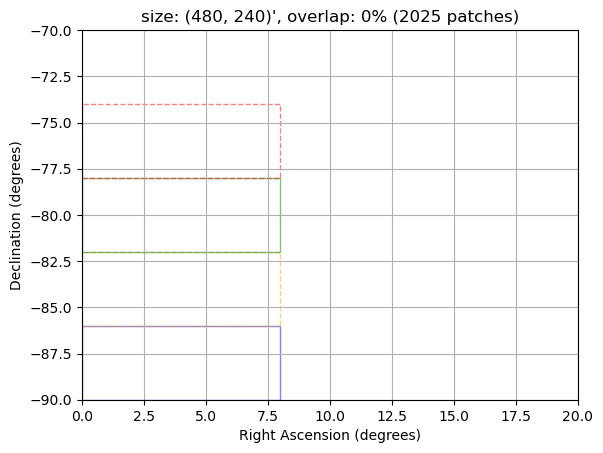

Number of patches in (RA, Dec): (50,50).
There were 2500 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 2500, 'arcminutes': (480, 240), 'overlap': 10}.
There are 2500 to plot.
Breaking at limit 3 passed to function.


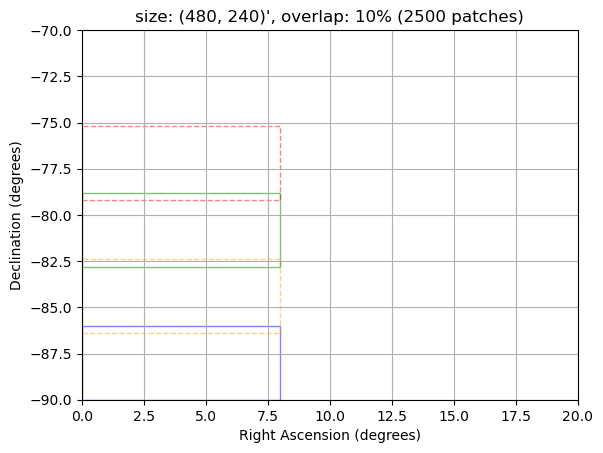

Number of patches in (RA, Dec): (56,56).
There were 3136 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 3136, 'arcminutes': (480, 240), 'overlap': 20}.
There are 3136 to plot.
Breaking at limit 3 passed to function.


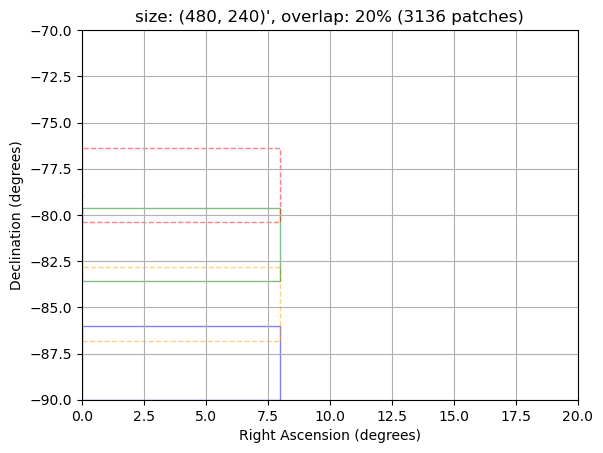

Number of patches in (RA, Dec): (64,64).
There were 4096 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 4096, 'arcminutes': (480, 240), 'overlap': 30}.
There are 4096 to plot.
Breaking at limit 3 passed to function.


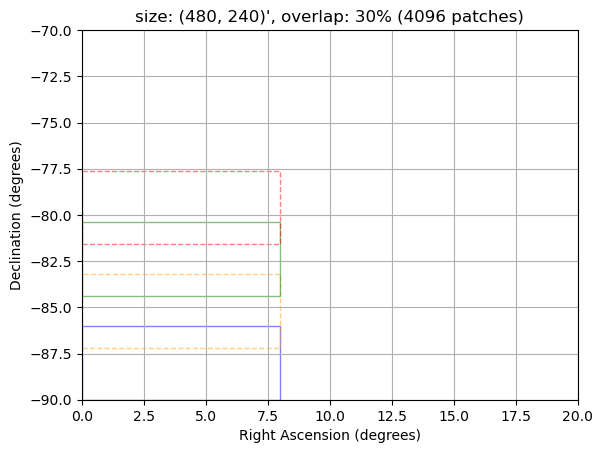

Number of patches in (RA, Dec): (75,75).
There were 5625 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 5625, 'arcminutes': (480, 240), 'overlap': 40}.
There are 5625 to plot.
Breaking at limit 3 passed to function.


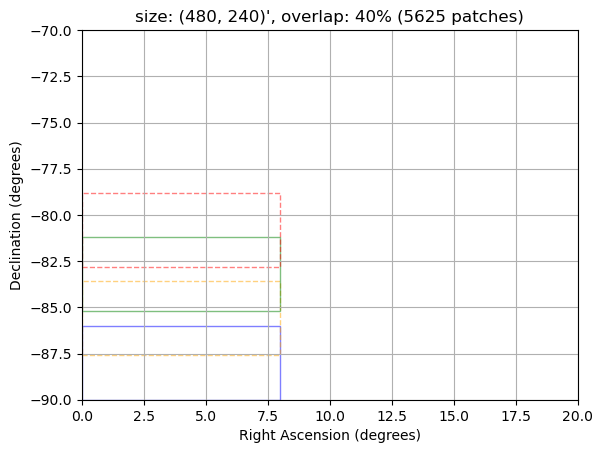

Number of patches in (RA, Dec): (90,90).
There were 8100 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 8100, 'arcminutes': (480, 240), 'overlap': 50}.
There are 8100 to plot.
Breaking at limit 3 passed to function.


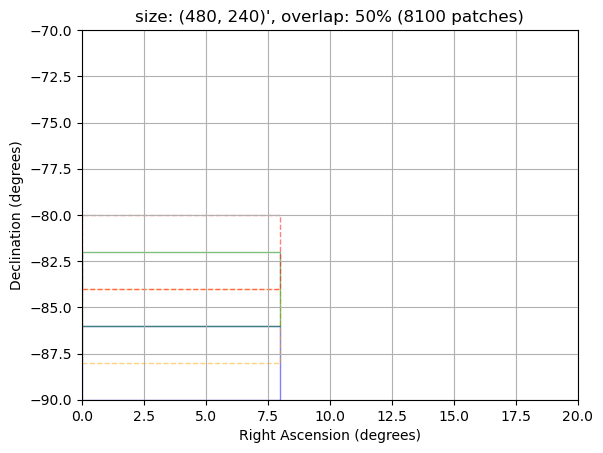

CPU times: user 1.9 s, sys: 1.4 s, total: 3.3 s
Wall time: 1.68 s


In [109]:
%%time

# TIMING NOTE: takes < 5 seconds to run 2/15/2024 COC

for i in [0, 10, 20, 30, 40, 50]:
    arcminutes_input = (8 * 60, 4 * 60)  # 8° X 4°
    patches_result, patches_centers, info = generate_patches(
        arcminutes_input,
        i,
        # decRange=[-90,61],
        export=False,
    )
    plot_patches(
        patches_result,
        xrange=[0, 20],
        yrange=[-90, -70],
        title=f"size: {info['arcminutes']}', overlap: {info['overlap']}% ({info['npatches']} patches)",
        subfolder="generic",
        limit=3,  # Just show the first 3 patches generated, otherwise results are visually overwhelming.
    )  # , limit=1000)

You can see the first set has no overlap at all, and each subsequent plot has further overlap.

In [110]:
# Rather than copying and pasting numbers, we make a dictionary to store parameters going forward.
chipDict = {}

chipDict["DECam"] = {"chipsize_arcmin": [9, 18]}  # 0.263"/pixel, (2048,4096) pix/chip = (8.98,17.95')/chip
chipDict["DECam"]["matches_per_sec"] = 20000  # sphgeom region matching; guess, TODO benchmark me
chipDict["DECam"]["chips_per_mo"] = 62 * 1900  # estimate; 1900/mo MAX 12/20/2023 COC (mean 708)
chipDict["DECam"]["dec_range"] = [-90, 90 - 30.1732]

chipDict["LSST"] = {"chipsize_arcmin": [14, 14]}  # 0.2"/pixel, (4096,4096) pix/chip = (13.65',13.65')/chip
chipDict["LSST"]["matches_per_sec"] = 20000  # sphgeom region matching; benchmarked; on RSP or local
chipDict["LSST"]["chips_per_mo"] = 6000000  # 2000/night * 30 nights/month
chipDict["LSST"]["dec_range"] = [-90, 30.1732]
# chipDict['LMI'] = [13,13] # 0.120"/pixel, (6144,6150) pix/chip = (12.288',12.3')/chip # just use LSST

chipDict["TEST"] = {"chipsize_arcmin": [3 * 60, 3 * 60]}  # 3 degree squares; 12/19/2023 COC
chipDict["TEST"]["matches_per_sec"] = 20000  # sphgeom region matching; reasonable estimate for testing
chipDict["TEST"]["chips_per_mo"] = 6000
chipDict["TEST"]["dec_range"] = [-90, 90]

This would be a good place to simulate benchmarks for region-region matching (visa lsst.sphgeom .intersect).\
The approach (demonstrated elsewhere) checks for any overlapping regions of two lsst.sphgeom regions.\
This is especially useful for handling arbitrarility rotated chips/images.\
In an early design, this was the approach to do our searching, but it was far too slow.\

In [111]:
# TODO: consider how we link this spot in the notebook to Region demo, etc. 2/15/2024 COC
# benchmarking, prettiertime, etc. would need to be brought here.

### Regions from Patches
Here we work on producing lsst.sphgeom regions (objects).\
The synthetic patch regions can be used as an interim step to filter out images (with 0 overlap).\
This is helpful to reduce clutter sent to Reproject, for example.

In [112]:
def latLonFromRaDecDeg(ra, dec, verbose=False):
    """
    Return a sphgeom LonLat object given an input RA, Dec (in degrees).
    We correct Dec values outside of ±90° (e.g., subtract 180 from Dec=90.1).
    """
    if dec > 90:
        print(f"WARNING: Dec > 90° ({dec}°) so subtracting 180°.")
        dec -= 180
    elif dec < -90:
        print(f"WARNING: Dec < -90° ({dec}°) so adding 180°.")
        dec += 180
    if ra > 360:
        print(f"WARNING: RA > 360° ({ra}°) so subtracting 360°.")
        ra -= 360
    elif ra < 0:  # just in case 1/9/2024 COC
        print(f"WARNING: RA < 0° ({ra}°) so adding 360°.")
        dec += 180
    t = lsst.sphgeom.LonLat(
        lsst.sphgeom._sphgeom.NormalizedAngle(np.deg2rad(ra)), lsst.sphgeom.Angle(np.deg2rad(dec))
    )
    return t

In [113]:
# Testing cases of invalid RA and Dec values.
print(latLonFromRaDecDeg(ra=45, dec=45))
print(latLonFromRaDecDeg(ra=361, dec=91))

[0.7853981633974483, 0.7853981633974483]
[0.017453292519943295, -1.5533430342749532]


In [114]:
def patches_to_sphgeom(input_data):
    """
    Convert a list of patches or FITS files to sphgeom regions.

    Parameters:
    - input_data: List of patches or FITS file paths.

    Returns:
    - List of sphgeom.SphericalPolygon objects.
    """

    def read_patch_fits(fits_path):
        # Read FITS file and extract WCS information
        hdul = fits.open(fits_path)
        wcs = astropy.wcs.WCS(hdul[0].header)

        # Extract coordinates from the WCS
        ra, dec = wcs.all_pix2world(np.array([0, 0]), np.array([0, 0]), 0)
        ra_start, dec_start = ra[0], dec[0]

        ra, dec = wcs.all_pix2world(
            np.array([hdul[0].data.shape[1], hdul[0].data.shape[0]]), np.array([1, 1]), 0
        )
        ra_end, dec_end = ra[0], dec[0]

    #         return sphgeom.ConvexPolygon.from_radec_sequence(
    #             [(ra_start, dec_start), (ra_start, dec_end), (ra_end, dec_end), (ra_end, dec_start)]
    #         )

    sphgeom_regions = []

    for item in input_data:
        if isinstance(item, tuple):
            # If it's a patch tuple, convert to sphgeom.SphericalPolygon
            ra_start, dec_start = item[0]
            ra_end, dec_end = item[1]
            box = lsst.sphgeom.Box(
                latLonFromRaDecDeg(ra_start, dec_start), latLonFromRaDecDeg(ra_end, dec_end)
            )
            sphgeom_regions.append(box)
        elif isinstance(item, str):
            # NOTE: untested 2/15/2024 COC TODO
            # If it's a FITS file path, read the file and convert to sphgeom.SphericalPolygon
            sphgeom_regions.append(read_patch_fits(item))
        else:
            raise ValueError(
                "Unsupported input type. Supported types are tuple (patch) or str (FITS file path)."
            )

    return sphgeom_regions


# Example usage:
# Assuming you have a list of patches or FITS file paths
# patches_or_fits = generate_patches(arcminutes_input, overlap_percentage_input)
# sphgeom_regions_result = patches_to_sphgeom(patches_or_fits)

In [115]:
%%time

test_patches_results, test_patches_centers, test_patches_info = generate_patches(
    chipDict["TEST"]["chipsize_arcmin"], 20
)

sphgeom_regions = patches_to_sphgeom(test_patches_results)

# Now we have a list of sphgeom.SphericalPolygon objects in sphgeom_regions_results

Number of patches in (RA, Dec): (150,75).
There were 11250 produced, skipping 0 because Dec was outside [-90, 90]. Info: {'npatches': 11250, 'arcminutes': [180, 180], 'overlap': 20}.
CPU times: user 320 ms, sys: 15.5 ms, total: 335 ms
Wall time: 334 ms


In [116]:
# first one of our example regions
sphgeom_regions[0]

Box(NormalizedAngleInterval.fromRadians(0.0, 0.05235987755982989), AngleInterval.fromRadians(-1.5707963267948966, -1.5184364492350666))

In [117]:
# sphgeom regions can be encoded for portability; these are "region hashes"
encoded = sphgeom_regions[0].encode()
encoded

b'b\x00\x00\x00\x00\x00\x00\x00\x00\xd6\xeb{\xf3\xe9\xce\xaa?\x18-DT\xfb!\xf9\xbf\xb9M\xa8\x04\x84K\xf8\xbf'

In [118]:
# Come back to an object
r = lsst.sphgeom.Region.decode(encoded)
r

Box(NormalizedAngleInterval.fromRadians(0.0, 0.05235987755982989), AngleInterval.fromRadians(-1.5707963267948966, -1.5184364492350666))

### Working with the Butler + Regions


In [119]:
# We should still have our example VisitInfo object from the Butler.
example_vdr_ref

visit_detector_region.RecordClass(instrument='DECam', detector=62, visit=946176, region=ConvexPolygon([UnitVector3d(0.9876086828694174, -0.13336028508776862, -0.08272922024438323), UnitVector3d(0.9873378171284917, -0.13332652431396907, -0.08595389916869185), UnitVector3d(0.9881047366097594, -0.12752395595185462, -0.08594573955553172), UnitVector3d(0.9883760335240734, -0.12755303452468866, -0.0827226676235914)]))

In [120]:
# Some example comparisons, using regions in our DataFrame
reg1 = df["region"].iloc()[0]
reg2 = df["region"].iloc()[-1]

In [121]:
# Basic reality testing first
print(f"reg1.contains(reg1) =  {reg1.contains(reg1)}")  # should be True
print(f"reg1.contains(reg2) = {reg1.contains(reg2)}")  # should be False

reg1.contains(reg1) =  True
reg1.contains(reg2) = False


In [122]:
# First we will look for the "contains" case, where one region completely contains another.
# We do not expect this for DEEP necessarily, but a region must contain itself, so we should see 1 match.

print(f"Checking overlap matches of reg1 against all records region for matchces...")
matches = []
for i, reg in enumerate(df["region"].iloc()):
    if reg.contains(reg1):
        matches.append(df["data_id"].iloc()[i])
print(f"There were {len(matches)} overlap matches:")
for i in matches:
    print(i)

Checking overlap matches of reg1 against all records region for matchces...
There were 1 overlap matches:
{'instrument': 'DECam', 'detector': 1, 'visit': 898286}


In [123]:
# Next we check "intersect" -- meaning any overlap of region area.

print(f"Checking intersect matches of reg1 against all records region for matchces...")
matches = []
for i, reg in enumerate(df["region"].iloc()):
    if reg.intersects(reg1):
        matches.append(df["data_id"].iloc()[i])
print(f"There were {len(matches)} intersection matches:")
for i in matches:
    print(i)

Checking intersect matches of reg1 against all records region for matchces...
There were 347 intersection matches:
{'instrument': 'DECam', 'detector': 1, 'visit': 898286}
{'instrument': 'DECam', 'detector': 1, 'visit': 898287}
{'instrument': 'DECam', 'detector': 1, 'visit': 898288}
{'instrument': 'DECam', 'detector': 1, 'visit': 898289}
{'instrument': 'DECam', 'detector': 1, 'visit': 898290}
{'instrument': 'DECam', 'detector': 1, 'visit': 898291}
{'instrument': 'DECam', 'detector': 1, 'visit': 898292}
{'instrument': 'DECam', 'detector': 1, 'visit': 898293}
{'instrument': 'DECam', 'detector': 1, 'visit': 898294}
{'instrument': 'DECam', 'detector': 1, 'visit': 898295}
{'instrument': 'DECam', 'detector': 1, 'visit': 898296}
{'instrument': 'DECam', 'detector': 1, 'visit': 898297}
{'instrument': 'DECam', 'detector': 1, 'visit': 898298}
{'instrument': 'DECam', 'detector': 1, 'visit': 898299}
{'instrument': 'DECam', 'detector': 1, 'visit': 898300}
{'instrument': 'DECam', 'detector': 1, 'visit

In [124]:
# lazily grabbing min and max Decs to limit number of patches we will produce for the dataset
ras = []
decs = []
for i in df["center_coord"]:
    ra = i[0]
    dec = i[1]
    ras.append(ra)
    decs.append(dec)
# deep_min_dec = min([df['center_coord'].iloc()[0][i])
minDec = min(decs)
maxDec = max(decs)
print(f"Saw minDec={minDec} and maxDec={maxDec}.")

# add a buffer of about a field radius
minDec -= 2.5
maxDec += 2.5
print(f"Will use minDec={minDec} and maxDec={maxDec}.")

Saw minDec=-6.406214566625444 and maxDec=-2.719246815973079.
Will use minDec=-8.906214566625444 and maxDec=-0.21924681597307893.


In [125]:
%%time
# Timing note: takes < 7 seconds 2/15/2024 COC

# First we want a set of sky patches. We are going to use 14' X 14' patches (LSST-size) as a test.
deep_patches_results, deep_patches_centers, deep_patches_info = generate_patches(
    arcminutes=chipDict["LSST"]["chipsize_arcmin"],
    overlap_percentage=0,
    verbose=True,
    decRange=[minDec, maxDec],
    export=False,
)
# convert the patches to sphgeom regions
sphgeom_regions_deep_limited = patches_to_sphgeom(deep_patches_results)

# Now you have a list of sphgeom.SphericalPolygon objects in sphgeom_regions_result

Number of patches in (RA, Dec): (1542,771).
There were 55512 produced, skipping 1133370 because Dec was outside [-8.906214566625444, -0.21924681597307893]. Info: {'npatches': 55512, 'arcminutes': [14, 14], 'overlap': 0}.
CPU times: user 6.48 s, sys: 70.5 ms, total: 6.55 s
Wall time: 6.56 s


In [126]:
# For the generalized Region Search, sky patches, we need a function for matching.
# making a function to test iterating and matching 1/12/2024 COC
# non-vectorized wanted > 1 hr to do this 2/15/2024 COC


def checkMatches(regions1, regions2):
    """
    regions1 will be our generated patches (sphgeom_regions)
    regions2 will be actual images (pointing_regions)
    updated 2/15/2024 COC
    """
    print(f"Starting region matching. Lens: region1 = {len(regions1)}, region2 = {len(regions2)}")
    startTime = time.time()
    matches = {}
    matches_attempted = 0
    progress_c = 0
    progress_interval = 10  # len(regions1)//200
    with progressbar.ProgressBar(max_value=len(regions1)) as bar:
        for i, patch in enumerate(regions1):
            matches[i] = []
            for j, pointing in enumerate(regions2):
                matches_attempted += 1
                if pointing.intersects(patch):
                    matches[i].append(j)
            progress_c += 1
            if progress_c >= progress_interval:
                progress_c = 0
                bar.update(i)

    elapsed = round(time.time() - startTime, 3)
    print(
        f"There were {len(matches)} matches in {matches_attempted} matches attempted. {len(matches_i)} region1s (patches?) and {len(matches_j)} region2s (pointings?) were involved. [{elapsed} s elapsed.]"
    )
    return matches

In [127]:
# import multiprocessing
# import time
# from progressbar import ProgressBar


def worker(patch_and_regions2):
    patch, regions2 = patch_and_regions2
    return [j for j, pointing in enumerate(regions2) if pointing.intersects(patch)]


def checkMatches(regions1, regions2):
    print(f"Starting region matching. Lens: region1 = {len(regions1)}, region2 = {len(regions2)}")
    startTime = time.time()

    # Prepare input for worker function
    input_for_worker = [(patch, regions2) for patch in regions1]

    # Use multiprocessing Pool
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(worker, input_for_worker)

    # Aggregate results
    matches = {i: result for i, result in enumerate(results)}

    elapsed = round(time.time() - startTime, 3)
    print(
        f"There were {sum(len(m) for m in matches.values())} matches in the {len(regions1)*len(regions2)} matches executed. [Elapsed time: {elapsed} s]"
    )

    return matches

In [128]:
%%time
# Timing note: this takes about 2 minutes 2/15/2024 COC
match_d = checkMatches(regions1=sphgeom_regions_deep_limited, regions2=df["region"])

Starting region matching. Lens: region1 = 55512, region2 = 47383
There were 192160 matches in the 2630325096 matches executed. [Elapsed time: 97.388 s]
CPU times: user 52.8 s, sys: 11.8 s, total: 1min 4s
Wall time: 1min 37s


In [129]:
%%time
matching_regions = []
matching_counts = []
for r in match_d:
    c = len(match_d[r])
    if c > 0:
        matching_regions.append(r)
        matching_counts.append(c)

CPU times: user 12.7 ms, sys: 4.38 ms, total: 17.1 ms
Wall time: 15.9 ms


In [130]:
# How many sky patches had images in them?
len(matching_regions)

264

/tmp/ipykernel_45553/2117250381.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Matching Images")


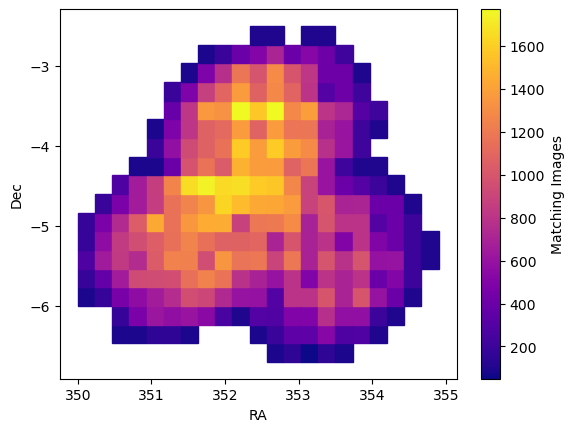

In [131]:
# Let us produce a heat map of how many images are in each sky patch.

# Assuming sphgeom_regions_deep_limited, matching_regions, and matching_counts are defined
# all_corners as defined in your original code
all_corners = [getRegionCorners(region) for region in sphgeom_regions_deep_limited]

# Define a colormap
cmap = plt.cm.plasma  # You can choose any available colormap

# Normalize your matching_counts to the colormap range (0, 1)
# This step is important for mapping your counts to colors
norm = mcolors.Normalize(vmin=min(matching_counts), vmax=max(matching_counts))

# Create a scalar mappable for coloring and creating the colorbar later
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the colorbar

# Plotting each quadrilateral with color based on matching_counts
for matching_ix, count in zip(matching_regions, matching_counts):
    quad = all_corners[matching_ix]
    ra_bounds, dec_bounds = getMinMaxRaDec(quad)

    coords = [
        (ra_bounds[0], dec_bounds[0]),
        (ra_bounds[0], dec_bounds[1]),
        (ra_bounds[1], dec_bounds[1]),
        (ra_bounds[1], dec_bounds[0]),
    ]

    # Use the normalized count to get the corresponding color
    color = cmap(norm(count))

    # Fill the quadrilateral with the selected color
    plt.fill(*zip(*coords), color=color)

# Add the colorbar to the plot
plt.colorbar(sm, label="Matching Images")

# Setting labels for clarity
plt.xlabel("RA")
plt.ylabel("Dec")
# plt.title('Heat Map by Counts')

plt.show()

# Next Steps

In no particular order:

1. User-specified (RA, Dec) pair: [DONE]
- from overlapping_sets (DONE 2/7/2024 COC)
- from our extracted Butler data (DONE 2/7/2024 COC)
2. Heat map / histogrammed results. [DONE 2/15/2024 COC]
- nice way to filter by top matches or the like
3. Sky patches approach. [DONE 2/14/2024 COC]
- matching before passing to reprojection / image collection
4. Handling time (manually)
- options to restrict date range
- options to restrict time delta
- visualize time information
5. Reflex correction.
6. Deduplicate based on URI? 2/26/2024 COC/WB (or maybe UT + RA + Dec)
7. DP 0.2 testing
- RA, Dec search
- Pulling out all of our metadata
8. Storing results
- what other metadata do we need
9. Region-region intersection function
10. Tracts-and-patches approach